This Nasdaq Stocks dataset was created by Javier Advani as a result of an automatic extraction of  open & public data available in nasdaq.com, using web scraping techniques. The only purpose of creating it was for academic reasons

https://zenodo.org/record/6368832#.Y-4ubuzMJmR

NASDAQ (National Association of Securities Dealers Automated Quotation) is the world's second largest automated and electronic stock exchange and securities market in the United States, the first being the New York Stock Exchange, with more than 8,000 companies and corporations. It has more trading volume per hour than any other stock exchange in the world. More than 7,000 small and mid-cap stocks are traded on the NASDAQ. It is characterized by comprising high-tech companies in electronics, computers, telecommunications, biotechnology, and many others.

### Methods: ###
- Exploratory analysis of data revealing some important features did not have enough observations to include.
- After removing observations with na values or bad data we analyzed 5457 of the original 8339 stocks.
- A future analysis might study all features using the 25% of available stocks to uncover any useful trends.
- The studied features were price, market cap, share volume, price percent change, and the categorical feature sector.
- There was very little correlation between the numerical features and they were not at all predictive of price percent change in linear analysis.
- Principal component analysis showed that the Technology sector accounted for most of the variance in the numerical features.
- t-SNE gave some results with a good clustering into 5 clusters at a perplexity of 30.
- K-means with 7 clusters suggested by the silhouette score found 
    - a group containing a diverse sector portfolio with high average share volume.
    - a group containing primarily technology stocks with the highest pricing percentage change.
    - a group consisting primarily of capital goods stocks with a positive pricing percentage change on average.
- K-Medoids gave the best results* using 3 clusters to find a collection of 20% of the stocks in a few sectors that perform very well collectively.
- The Gaussian mixture model did not reveal much in the data.
- None of the linkage methods in hierarchical clustering were able to distinguish useful patterns in the data.

### Outcome: ###
- K-Medoids identified the best portfolio options for stock performance on this particular day. It would be interesting to see how the basket of stocks performs over time in relation to the full Nasdaq data set.

In [7]:
import pandas as pd

import numpy as np

import matplotlib.pylab as plt

import seaborn as sns

from functools import reduce

# Importing linear regression model
from sklearn import linear_model
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

# To scale the data using z-score 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

# Importing PCA and t-SNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Importing sklearn LDA and QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import warnings
warnings.filterwarnings("ignore")

In [8]:
data = pd.read_csv("2022_03_17_02_06_nasdaq.csv")

data.head()

,Unnamed: 0,symbol,name,price,pricing_changes,pricing_percentage_changes,sector,industry,market_cap,share_volume,earnings_per_share,annualized_dividend,dividend_pay_date,symbol_yield,beta,errors
0,0,AAPL,Apple Inc. Common Stock,157.510,+2.42,(+1.56%),Technology,Computer Manufacturing,"2,699,423,838,000","63,429,579",$6.04,$0.88,"Feb 10, 2022",0.58%,1.18,False
1,1,MSFT,Microsoft Corporation Common Stock,289.560,+2.41,(+0.84%),Technology,Computer Software: Prepackaged Software,"2,143,429,080,429","22,790,662",$9.39,$2.48,"Jun 9, 2022",0.9%,0.91,False
2,2,GOOG,Alphabet Inc. Class C Capital Stock,2639.755,+46.545,(+1.79%),Technology,Internet and Information Services,"1,724,718,735,878","900,760",$112.23,NaN,NaN,NaN,1.06,False
3,3,GOOGL,Alphabet Inc. Class A Common Stock,2629.010,+45.05,(+1.74%),Technology,Internet and Information Services,"1,718,961,675,672","1,008,687",$112.23,NaN,NaN,NaN,1.06,False
4,4,AMZN,"Amazon.com, Inc. Common Stock",3009.070,+61.74,(+2.09%),Consumer Services,Catalog/Specialty Distribution,"1,511,267,897,700","2,623,915",$64.78,NaN,NaN,NaN,1.11,False


In [9]:
df = data.copy()

# linear regression study on symbol_yield
df_linear = data.copy()
# Will make another copy for cluster techniques after data cleaning

### Data Pre-processing and EDA ###

In [662]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8339 entries, 0 to 8338
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  8339 non-null   int64  
 1   symbol                      8339 non-null   object 
 2   name                        8339 non-null   object 
 3   price                       8339 non-null   float64
 4   pricing_changes             8339 non-null   object 
 5   pricing_percentage_changes  5990 non-null   object 
 6   sector                      6138 non-null   object 
 7   industry                    6156 non-null   object 
 8   market_cap                  6824 non-null   object 
 9   share_volume                7853 non-null   object 
 10  earnings_per_share          2921 non-null   object 
 11  annualized_dividend         2198 non-null   object 
 12  dividend_pay_date           2262 non-null   object 
 13  symbol_yield                3783 

There are many null values in this dataset. Imputing values in most of these cases is not simple. The percentage of missing values ranges from 25-75% of the dataset. Our goal will to keep as many observations and columns as possible while retaining 80% of the data.

The earnings_per_share, annualized_dividend, dividend_pay_date, and symbol_yield columns are each non-null in about 25% of the stocks. These are important values in determining a portfolio but there is not enough data so we will drop these columns for this analysis. A second analysis should be performed on this subset of the data but we do not do that here.

We drop the null values for price, pricing_changes, market_cap, and share_volume leaving about 80% of the stocks in the dataframe.

We can calculate pricing_percentage_changes for all stocks on our own so we will drop that column for now.

We can also drop the errors column.

In [10]:
# drop null values
df_linear.dropna(subset=['price','pricing_changes','market_cap','share_volume','sector'], inplace=True)
# drop columns with high percentage of null values
df_linear.drop(columns = ['Unnamed: 0','industry','pricing_percentage_changes','earnings_per_share','annualized_dividend','dividend_pay_date','symbol_yield','errors','beta'], axis = 1, inplace = True)

In [664]:
df_linear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5457 entries, 0 to 7726
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   symbol           5457 non-null   object 
 1   name             5457 non-null   object 
 2   price            5457 non-null   float64
 3   pricing_changes  5457 non-null   object 
 4   sector           5457 non-null   object 
 5   market_cap       5457 non-null   object 
 6   share_volume     5457 non-null   object 
dtypes: float64(1), object(6)
memory usage: 341.1+ KB


In [11]:
# Cleaning the data

# remove rows with bad data
# format data string and type as float, e.g., 591,325,000,000 to 591325000000.0
df_linear = df_linear[~df_linear['market_cap'].isin(['$12.84/$4.61','$2.38/$0.65'])]
df_linear['market_cap'] = df_linear['market_cap'].str.replace(',','') #if df_sym_yield['market_cap'].dtypes == str else df_sym_yield['market_cap']
df_linear['market_cap'] = df_linear['market_cap'].astype(np.float64)

# format data string and type as float, e.g., 63,429,579 to 63429579.0
df_linear['share_volume'] = df_linear['share_volume'].str.replace(',','') #if df_sym_yield['share_volume'].dtypes == str else df_sym_yield['share_volume']
df_linear['share_volume'] = df_linear['share_volume'].astype(np.float64)

# format data string and type as float, e.g., +2.42 to 2.42
df_linear['pricing_changes'] = np.where(df_linear['pricing_changes'].dtypes == str, df_linear['pricing_changes'].str.replace('+',''), df_linear['pricing_changes'])
df_linear['pricing_changes'] = np.where(df_linear['pricing_changes'] == 'Unchanged', 0, df_linear['pricing_changes'])
df_linear['pricing_changes'] = df_linear['pricing_changes'].astype(np.float64)

# calculate the dropped pricing_percentage_changes column
df_linear['pricing_percentage_changes'] = np.where(df_linear['price'] == 0, 0, df_linear['pricing_changes']/df_linear['price'])


We no longer need pricing_changes as this information is better reflected in pricing_percentage_changes.

In [12]:
df_linear.drop(['pricing_changes'], axis=1, inplace=True)

We can drop the symbol and name columns from the dataframe

In [15]:
df_linear.drop(['symbol','name'], axis=1, inplace=True)

We now have 5457 stocks in the dataset with no missing values.

<Axes: >

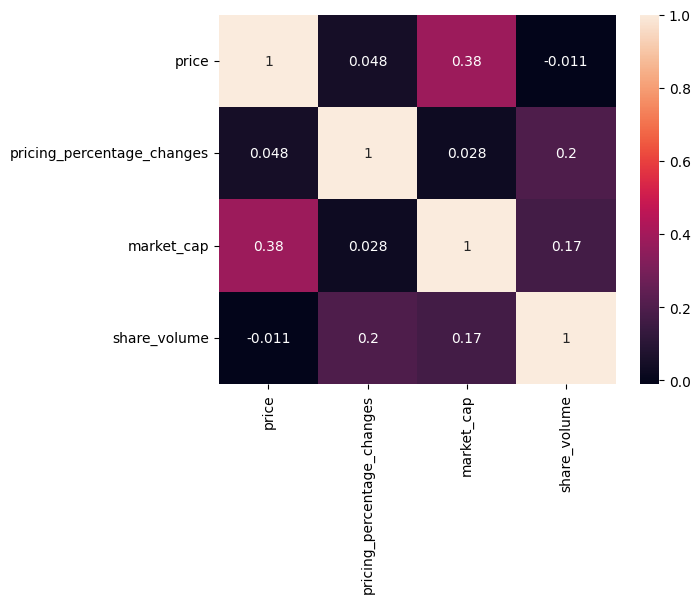

In [16]:
num_col=['price','pricing_percentage_changes','market_cap','share_volume']
corr=df_linear[num_col].corr()
sns.heatmap(corr, annot=True)

There seems to be some correlation between price and market_cap which is to be expected.

The sectors represented in this collection of stocks and their average price percentage changes are as follows. Each sector is heavily right skewed. There are 12 different sectors.

In [17]:
count = pd.DataFrame(df_linear['sector'].value_counts()).rename(columns={'sector':'count'})
count.index.name = 'sector'
med = pd.DataFrame(df_linear.groupby('sector')['pricing_percentage_changes'].median()).rename(columns={'pricing_percentage_changes':'median'})
mean = pd.DataFrame(df_linear.groupby('sector')['pricing_percentage_changes'].mean()).rename(columns={'pricing_percentage_changes':'mean'})
data_frames = [count,med,mean]
sector_df = reduce(lambda  left,right: pd.merge(left,right, on=['sector'], how='outer'), data_frames)
sector_df

,count,median,mean
sector,,,
Finance,1290,0.001022,0.008946
Health Care,1079,0.000000,0.010611
Technology,778,0.009297,0.022717
Consumer Services,661,0.001704,0.012423
Capital Goods,438,0.004636,0.013688
Consumer Non-Durables,213,0.007528,0.015994
Energy,202,0.000000,-0.001168
Basic Industries,201,0.001634,0.010915
Public Utilities,166,0.000000,0.003888


**Strategy:**
- We can study how feature values affect pricing_percentage_change for this day. We would ultimately want to do this over time.

One hot encoding of categorical variables sector and industry.

In [18]:
# Creating dummy variables for the categorical variables
df_linear = pd.get_dummies(df_linear, drop_first = True)

df_linear.head()

df_cluster = df_linear.copy()

In [19]:
target_df = df_linear[['pricing_percentage_changes']].copy()
df_linear.drop(['pricing_percentage_changes'], axis=1, inplace=True)

In [20]:
# Scaling the data
sc = StandardScaler()

df_linear_scaled = sc.fit_transform(df_linear)

df_linear_scaled = pd.DataFrame(df_linear_scaled, index = df_linear.index, columns = df_linear.columns)

In [673]:
# Adding the intercept term
df_linear_scaled = sm.add_constant(df_linear_scaled)

# Calling the OLS algorithm on the train features and the target variable
ols_model_0 = sm.OLS(target_df, df_linear_scaled)

# Fitting the Model
ols_res_0 = ols_model_0.fit()

print(ols_res_0.summary())

                                OLS Regression Results                                
Dep. Variable:     pricing_percentage_changes   R-squared:                       0.068
Model:                                    OLS   Adj. R-squared:                  0.066
Method:                         Least Squares   F-statistic:                     28.35
Date:                        Mon, 06 Mar 2023   Prob (F-statistic):           3.82e-73
Time:                                14:58:41   Log-Likelihood:                 11110.
No. Observations:                        5455   AIC:                        -2.219e+04
Df Residuals:                            5440   BIC:                        -2.209e+04
Df Model:                                  14                                         
Covariance Type:                    nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

#### Observations: ####
The R-squared value is 0.122 so this linear model explains very little of the variability in the data.

We can look at linearity by variable by hand just for fun.

In [674]:
# save features as individual arrays
price = df_linear_scaled.price.values.reshape(len(target_df['pricing_percentage_changes']), 1)
market_cap = df_linear_scaled.market_cap.values.reshape(len(target_df['pricing_percentage_changes']), 1)
share_volume = df_linear_scaled.share_volume.values.reshape(len(target_df['pricing_percentage_changes']), 1)

In [680]:
pricing_percentage_changes = target_df.pricing_percentage_changes.values.reshape(len(target_df['pricing_percentage_changes']), 1)

In [681]:
# create regression model object
# train model
# get regression model intercept and coefficient
# create list containing intercept and coefficient

price_model = linear_model.LinearRegression()
price_model.fit(price, pricing_percentage_changes)
coeffs_price = np.array(list(price_model.intercept_.flatten()) + list(price_model.coef_.flatten()))
coeffs_price = list(coeffs_price)

market_cap_model = linear_model.LinearRegression()
market_cap_model.fit(market_cap, pricing_percentage_changes)
coeffs_market_cap = np.array(list(market_cap_model.intercept_.flatten()) + list(market_cap_model.coef_.flatten()))
coeffs_market_cap = list(coeffs_market_cap)

share_volume_model = linear_model.LinearRegression()
share_volume_model.fit(share_volume, pricing_percentage_changes)
coeffs_share_volume = np.array(list(share_volume_model.intercept_.flatten()) + list(share_volume_model.coef_.flatten()))
coeffs_share_volume = list(coeffs_share_volume)

In [682]:
# create dictionary of intercepts and coefficients
dict_linear = {}
dict_linear["price"] = coeffs_price
dict_linear["market_cap"] = coeffs_market_cap
dict_linear["share_volume"] = coeffs_share_volume

In [683]:
# create dataframe from coefficient dictionary
metric_Df_SLR =  pd.DataFrame(dict_symbol_yield)
# set indices as intercept and coefficients
metric_Df_SLR.index = ['Intercept', 'Coefficient']

In [684]:
# get regression model scores
price_rsq = price_model.score(price, pricing_percentage_changes)
market_cap_rsq = market_cap_model.score(market_cap, pricing_percentage_changes)
share_volume_rsq = share_volume_model.score(share_volume, pricing_percentage_changes)

In [685]:
# create list of regression model scores
list_rsq = [price_rsq, market_cap_rsq, share_volume_rsq]
list_rsq

[0.002315939839338199, 0.000800064941100187, 0.03885371071366017]

In [687]:
# add regression model scores to metric dataframe with index R-Squared
metric_Df_SLR.loc['R-Squared'] = list_rsq
metric_Df_SLR

,price,market_cap,share_volume
Intercept,0.012296,0.012296,0.012296
Coefficient,0.001574,0.000925,0.006445
R-Squared,0.002316,0.000800,0.038854


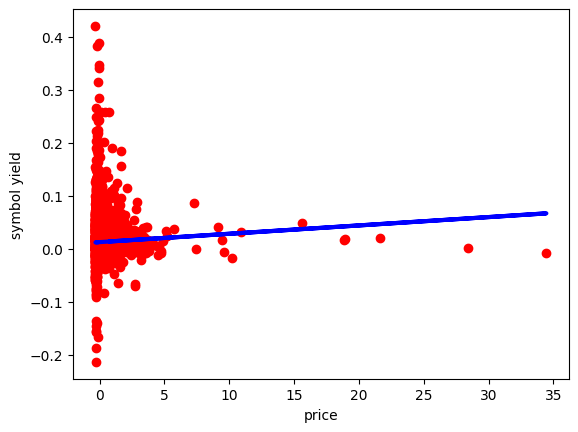

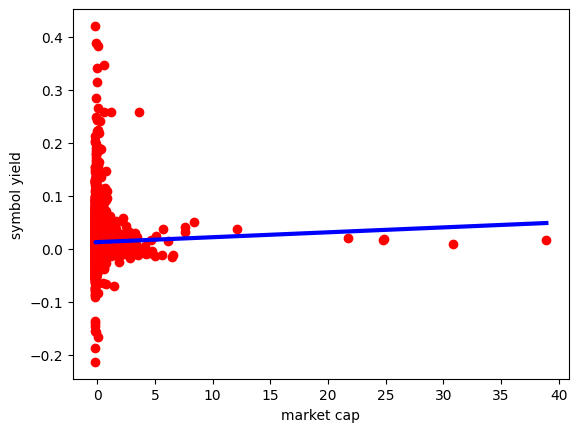

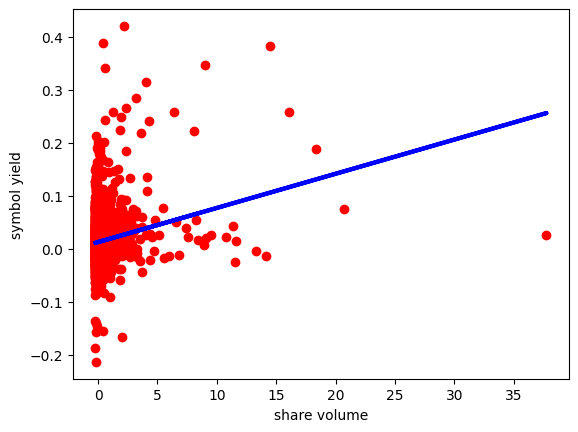

In [688]:
# create scatter plot of feature and target (symbol_yield)
# create regression line from model
plt.scatter(price, pricing_percentage_changes,  color='red')
plt.xlabel('price')
plt.ylabel('symbol yield')
plt.plot(price, price_model.predict(price), color='blue', linewidth=3)
plt.show()

plt.scatter(market_cap, pricing_percentage_changes,  color='red')
plt.xlabel('market cap')
plt.ylabel('symbol yield')
plt.plot(market_cap, market_cap_model.predict(market_cap), color='blue', linewidth=3)
plt.show()

plt.scatter(share_volume, pricing_percentage_changes,  color='red')
plt.xlabel('share volume')
plt.ylabel('symbol yield')
plt.plot(share_volume, share_volume_model.predict(share_volume), color='blue', linewidth=3)
plt.show()

In [690]:
# create multiple linear regression model
mlr_model = linear_model.LinearRegression()
# fit data / train model
mlr_model.fit(df_linear[['price', 'market_cap', 'share_volume']], target_df['pricing_percentage_changes'])

LinearRegression()

In [691]:
# predict symbol yield
df_linear['Price_Percentage_Change_Predicted']  = mlr_model.predict(df_linear[['price', 'market_cap', 'share_volume']]) 
# calculate prediction error as difference squared
df_linear['Error'] = (df_linear['Price_Percentage_Change_Predicted'] - target_df['pricing_percentage_changes'])**2
# calculate the mean error
MSE_MLR = df_linear['Error'].mean()
MSE_MLR

0.0010241051104498769

In [692]:
# calculate the coefficient of determination of the prediction score R^2
mlr_model.score(df_linear[['price', 'market_cap', 'share_volume']], target_df['pricing_percentage_changes'])

0.04207817508953038

**Observations:**
- data is highly non-linear
- need to do unsupervised learning study

In [695]:
df_cluster.describe().T

,count,mean,std,min,25%,50%,75%,max
price,5455.0,4.426698e+01,1.372707e+02,0.163000,5.515000e+00,1.480000e+01,4.084000e+01,4.773730e+03
market_cap,5455.0,1.024859e+10,6.906241e+10,-200.750000,1.481522e+08,7.012892e+08,3.664087e+09,2.699424e+12
share_volume,5455.0,1.620402e+06,7.350206e+06,54.000000,7.891250e+04,2.969300e+05,9.498900e+05,2.790211e+08
pricing_percentage_changes,5455.0,1.229647e-02,3.269995e-02,-0.213592,0.000000e+00,1.023541e-03,2.130380e-02,4.199462e-01
sector_Capital Goods,5455.0,8.029331e-02,2.717717e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
sector_Consumer Durables,5455.0,2.768103e-02,1.640723e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
sector_Consumer Non-Durables,5455.0,3.904675e-02,1.937240e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
sector_Consumer Services,5455.0,1.211732e-01,3.263584e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
sector_Energy,5455.0,3.703025e-02,1.888532e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
sector_Finance,5455.0,2.364803e-01,4.249594e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


price
Skew : 18.32


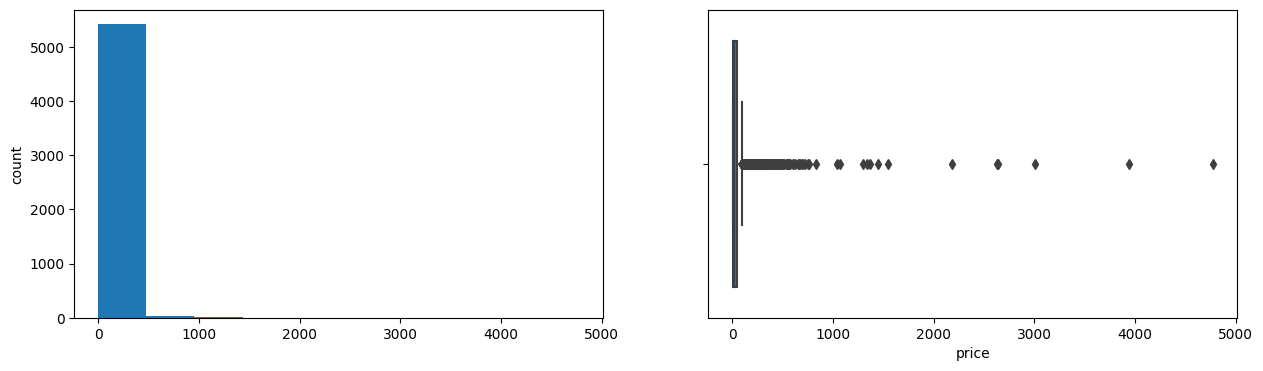

pricing_percentage_changes
Skew : 3.05


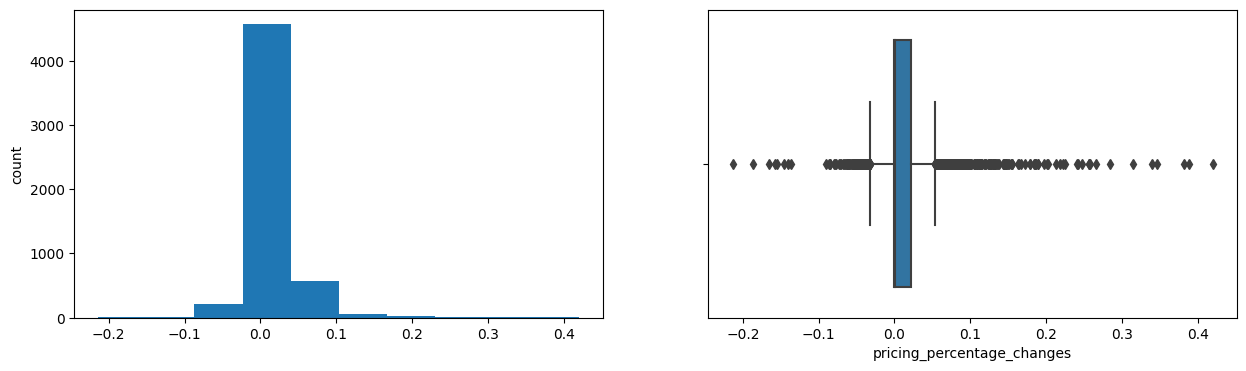

market_cap
Skew : 24.85


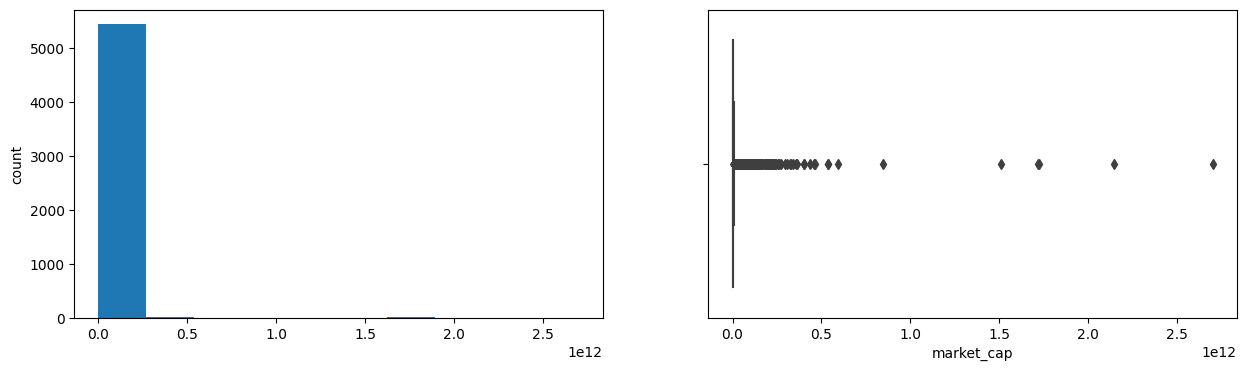

share_volume
Skew : 17.69


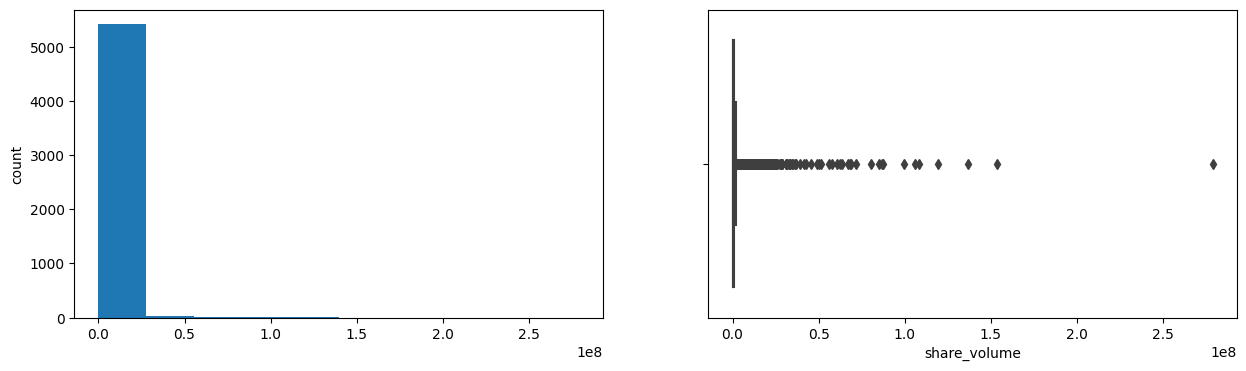

In [696]:
columns = ['price','pricing_percentage_changes','market_cap','share_volume']

for col in columns:
    print(col)
    
    print('Skew :', round(df_cluster[col].skew(), 2))
    
    plt.figure(figsize = (15, 4))
    
    plt.subplot(1, 2, 1)
    
    df_cluster[col].hist(bins = 10, grid = False)
    
    plt.ylabel('count')
    
    plt.subplot(1, 2, 2)
    
    sns.boxplot(x = df_cluster[col])
    
    plt.show()

**Observations:**
- There is no strong correlation between any one variable and the others so a supervised learning model would not be of much use.

### Unsupervised Learning Exploration ###

In [697]:
# To scale the data using z-score 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_cluster_scaled = pd.DataFrame(scaler.fit_transform(df_cluster), columns = df_cluster.columns)

print(df_cluster_scaled['price'].mean())
print(df_cluster_scaled['price'].std())

-6.252255053434429e-17
1.000091671632406


The mean is 0 and std dev is 1.

### Principal Component Analysis ###

In [698]:
# Defining the number of principal components to generate
n = df_cluster_scaled.shape[1]

# Finding principal components for the data
pca = PCA(n_components = n, random_state = 1)

df_cluster_pca = pd.DataFrame(pca.fit_transform(df_cluster_scaled))

# The percentage of variance explained by each principal component
exp_var = pca.explained_variance_ratio_

df_cluster_pca.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25.461930,6.581948,10.461982,8.043201,-2.363526,-1.396735,5.339224,1.762305,-0.028341,-0.901718,-1.347682,7.015576,12.156305,22.143164,0.015825
1,19.524627,5.830512,9.423326,6.704432,-2.371558,-2.334756,2.531331,0.461030,0.060996,-1.158580,-1.285687,3.473249,7.830428,18.157302,0.012317
2,23.480821,9.133713,14.992068,8.128112,-3.321188,-2.750725,-0.885415,-1.663728,0.523084,-2.825921,-1.476127,-0.703010,0.016885,4.722018,-0.020593
3,23.398337,9.099081,14.934151,8.098790,-3.307956,-2.747948,-0.879278,-1.653913,0.520218,-2.813577,-1.471157,-0.696232,0.039726,4.706597,-0.020717
4,22.518662,9.409893,16.908375,5.291521,-4.373033,-0.583822,-0.763053,-1.580550,0.536545,-2.858756,-1.318497,-0.491818,-1.842397,1.207337,-0.032329
5,10.843681,3.384129,5.992613,2.702542,1.638019,1.320777,-0.427921,0.465591,-0.138332,-0.519137,-0.582356,1.651494,1.624682,3.969110,-0.033028
6,8.948604,0.870161,0.089137,2.097376,-0.475332,-0.056703,2.127829,1.332655,-0.163047,0.203001,-0.142467,3.293630,4.023869,2.394350,-0.042023
7,6.078226,1.040495,0.800879,1.898457,-0.800859,-1.316546,0.314960,0.312986,-0.090500,-0.132970,-0.333724,0.908544,2.304685,4.165583,-0.029288
8,7.239437,0.968778,0.490703,1.956098,-0.658525,-0.767812,1.020700,0.718384,-0.116102,-0.003430,-0.243970,1.845814,2.865016,3.036205,-0.035764
9,4.524918,0.608044,4.766582,2.898020,-1.055936,-0.158445,0.203563,-0.133013,0.067802,-0.589098,-0.376144,0.357977,0.914623,2.081496,-0.032123


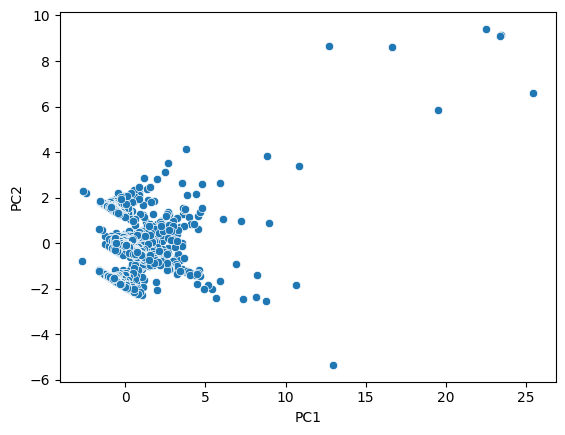

In [699]:
# Plot PC1 against PC2

sns.scatterplot(x = df_cluster_pca[0], y = df_cluster_pca[1])

plt.xlabel("PC1")

plt.ylabel("PC2")

plt.show()

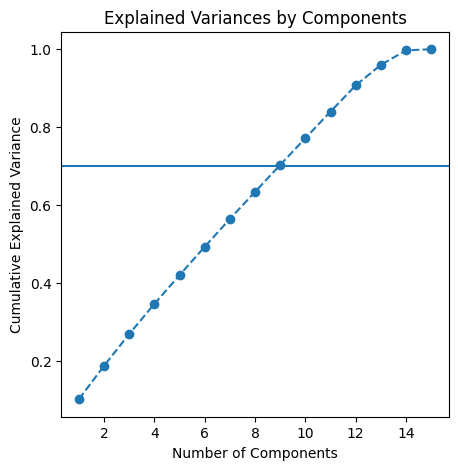

In [701]:
# Plotting the explained cumulative variance by principal components
plt.figure(figsize = (5, 5))

plt.plot(range(1, 16), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')

plt.title("Explained Variances by Components")

plt.xlabel("Number of Components")

plt.ylabel("Cumulative Explained Variance")

plt.axhline(y=0.7)

plt.show()

In [702]:
# Finding the least number of components that can explain more than 70% variance
sum = 0

for ix, i in enumerate(exp_var):

    sum = sum + i
    
    if(sum>0.70):
        
        print("Number of PCs that explain at least 70% variance:", ix + 1)
        break

Number of PCs that explain at least 70% variance: 9


In [703]:
# Create dataframe of PCA
pc_comps = ['PC1', 'PC2', 'PC3']

df_cluster_pca = pd.DataFrame(np.round(pca.components_[:3,:],2), index = pc_comps, columns = df_cluster_scaled.columns)

df_cluster_pca.T

,PC1,PC2,PC3
price,0.48,0.25,0.42
market_cap,0.54,0.19,0.35
share_volume,0.36,-0.10,-0.23
pricing_percentage_changes,0.33,-0.14,-0.45
sector_Capital Goods,0.10,0.00,0.09
sector_Consumer Durables,-0.06,-0.03,0.00
sector_Consumer Non-Durables,0.05,-0.03,-0.03
sector_Consumer Services,0.08,-0.01,0.18
sector_Energy,-0.03,0.01,0.15
sector_Finance,-0.28,0.70,-0.15


In [705]:
# Add colors to high abs value scores
def color_high(val):
    
    if val < -0.25:
        return 'background: pink'
    
    elif val > 0.25:
        return 'background: skyblue'   
    
df_cluster_pca.T.style.applymap(color_high)

,PC1,PC2,PC3
price,0.480000,0.250000,0.420000
market_cap,0.540000,0.190000,0.350000
share_volume,0.360000,-0.100000,-0.230000
pricing_percentage_changes,0.330000,-0.140000,-0.450000
sector_Capital Goods,0.100000,0.000000,0.090000
sector_Consumer Durables,-0.060000,-0.030000,0.000000
sector_Consumer Non-Durables,0.050000,-0.030000,-0.030000
sector_Consumer Services,0.080000,-0.010000,0.180000
sector_Energy,-0.030000,0.010000,0.150000
sector_Finance,-0.280000,0.700000,-0.150000


### t-SNE ###

In [810]:
# Fitting t-SNE with number of components equal to 2 
tsne = TSNE(n_components = 2, random_state = 1)

df_cluster_tsne = tsne.fit_transform(df_cluster_scaled)

In [811]:
# Converting the embeddings to a dataframe
df_cluster_tsne = pd.DataFrame(df_cluster_tsne, columns = ['X1', 'X2'])

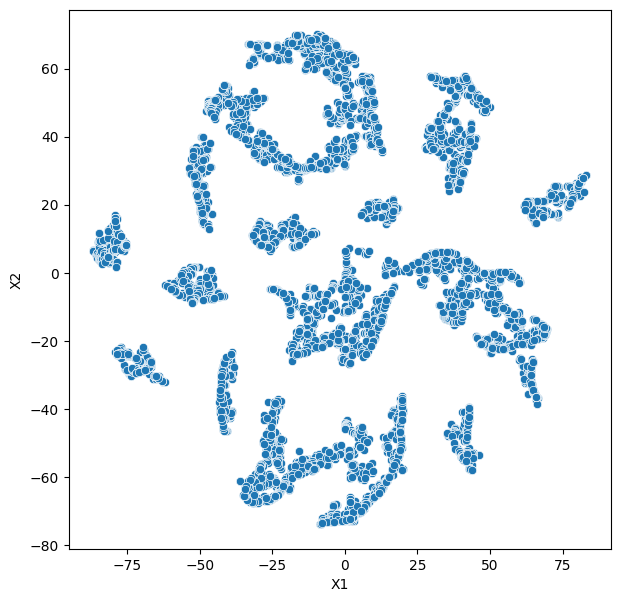

In [812]:
# Scatter plot for two components
plt.figure(figsize = (7,7))

sns.scatterplot(x = 'X1', y = 'X2', data = df_cluster_tsne)

plt.show()

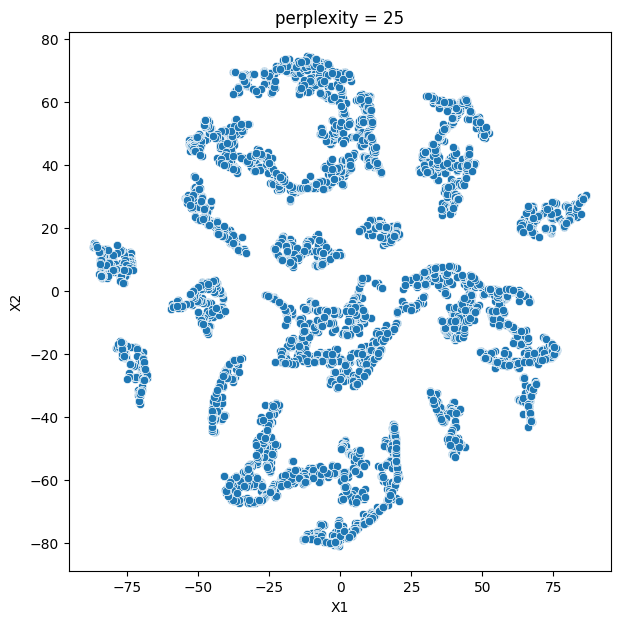

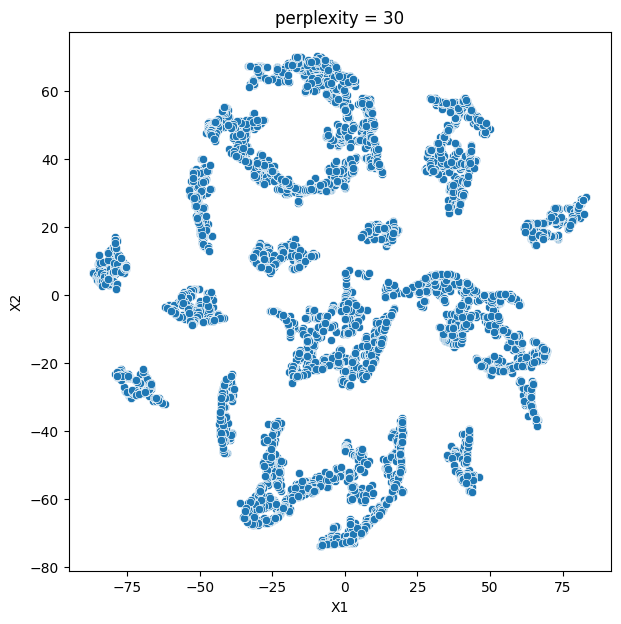

In [92]:
for i in range(25, 35, 5):
    tsne = TSNE(n_components = 2, random_state = 1, perplexity = i)
    
    df_cluster_tsne = tsne.fit_transform(df_cluster_scaled)
    
    df_cluster_tsne = pd.DataFrame(df_cluster_tsne)
    
    df_cluster_tsne.columns = ['X1', 'X2']
    
    plt.figure(figsize = (7,7))
    
    sns.scatterplot(x = 'X1', y = 'X2', data = df_cluster_tsne)
    
    plt.title("perplexity = {}".format(i))

In [813]:
# Let's assign points to 5 different groups
def grouping(x):
    first_component = x['X1']
    
    second_component = x['X2']
    
    if -50 < second_component < 42 and first_component < -32:
        return 'group_1'
    
    elif -30 < second_component < 18 and first_component < 25:
        return 'group_2'

    elif -50 < second_component < 10 and first_component > 22:
        return 'group_3'
    
    elif 16 < second_component:
        return 'group_4'    
 
    else: 
        return 'group_5'

In [720]:
df_cluster_tsne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5455 entries, 0 to 5454
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      5455 non-null   float32
 1   X2      5455 non-null   float32
dtypes: float32(2)
memory usage: 42.7 KB


In [814]:
df_cluster_tsne['groups'] = df_cluster_tsne.apply(grouping, axis = 1)

,X1,X2,groups
0,5.577199,6.282057,group_2
1,5.545896,6.278396,group_2
2,4.722797,6.340280,group_2
3,4.723143,6.340206,group_2
4,4.641765,6.346739,group_2
...,...,...,...
5450,-38.032265,-27.581581,group_1
5451,14.925562,3.651441,group_2
5452,52.827202,-6.295013,group_3
5453,-46.816051,12.968179,group_1


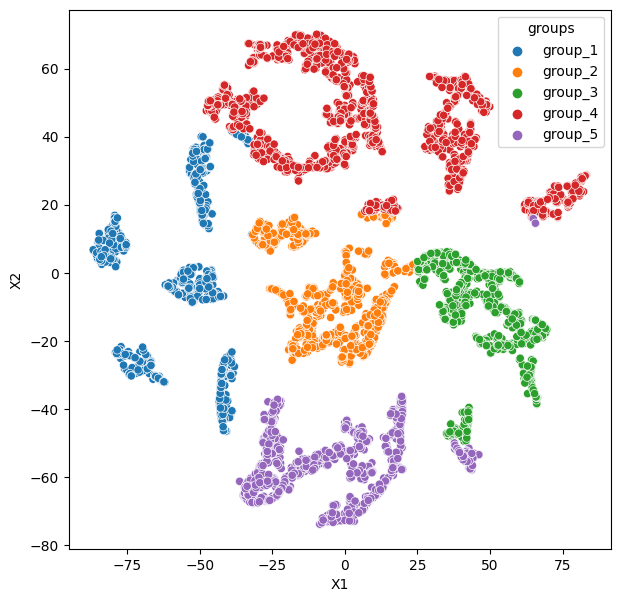

In [815]:
# Scatter plot for two components with hue
plt.figure(figsize = (7, 7))

sns.scatterplot(x = 'X1', y = 'X2', data = df_cluster_tsne.sort_values('groups'), hue = 'groups')
df_cluster_tsne

In [816]:
order = pd.Series(df_cluster_tsne_price_drop['groups'].unique()).sort_values()

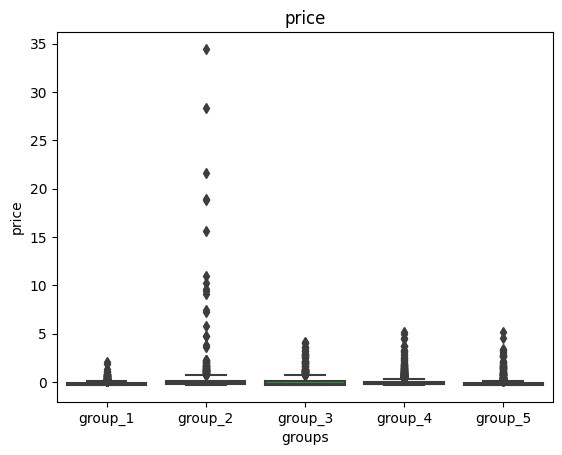

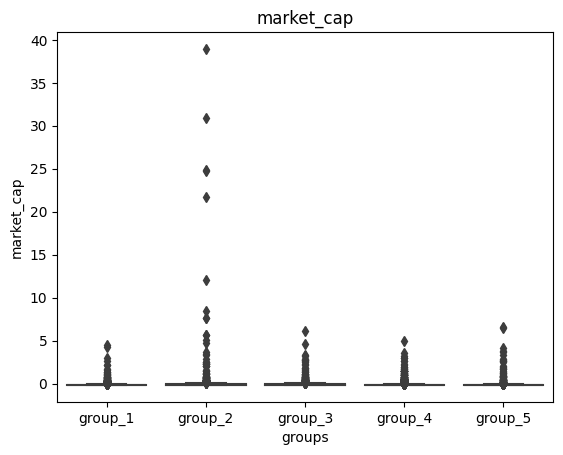

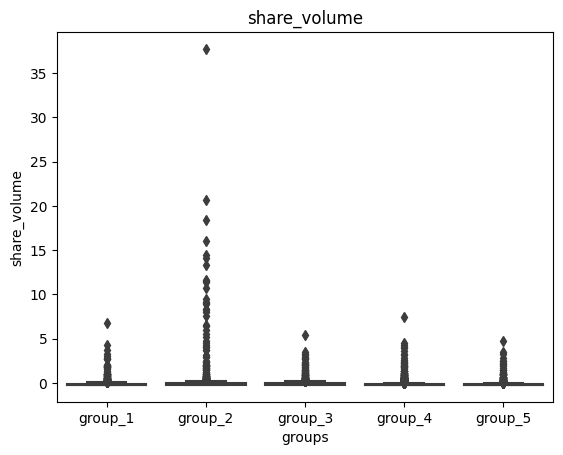

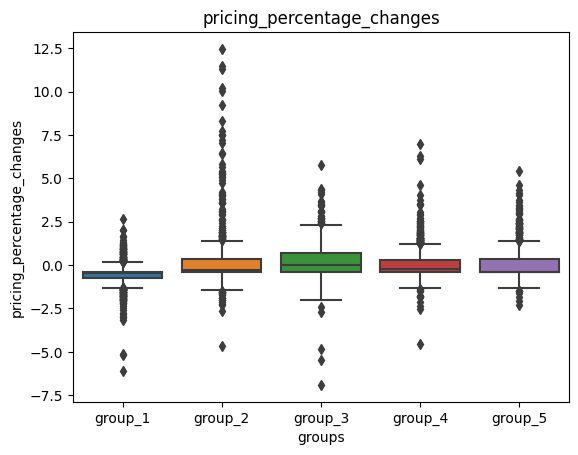

In [817]:
num_col = ['price', 'market_cap', 'share_volume','pricing_percentage_changes']

#plt.figure(figsize = (50, 50))

for i, variable in enumerate(num_col):
    
    sns.boxplot(y=df_cluster_scaled[variable], x=df_cluster_tsne['groups'], order = order)
    
    plt.title(variable)

    plt.show()

In [818]:
# Removing outliers to get more expressive boxplots

index = df_cluster_scaled[(df_cluster_scaled['price'] > 1.5)].index
df_cluster_tsne_price_drop = df_cluster_tsne.drop(index , axis=0)                    
                         
index = df_cluster_scaled[(df_cluster_scaled['market_cap'] > 0.2)].index
df_cluster_tsne_market_cap_drop = df_cluster_tsne.drop(index , axis=0)

index = df_cluster_scaled[(df_cluster_scaled['share_volume'] > 0.6)].index
df_cluster_tsne_share_volume_drop = df_cluster_tsne.drop(index , axis=0)

index = df_cluster_scaled[(df_cluster_scaled['pricing_percentage_changes'] > 2.5)].index
df_cluster_tsne_pricing_changes_drop = df_cluster_tsne.drop(index , axis=0)
index = df_cluster_scaled[(df_cluster_scaled['pricing_percentage_changes'] < -1)].index
df_cluster_tsne_pricing_changes_drop2 = df_cluster_tsne_pricing_changes_drop.drop(index , axis=0)   

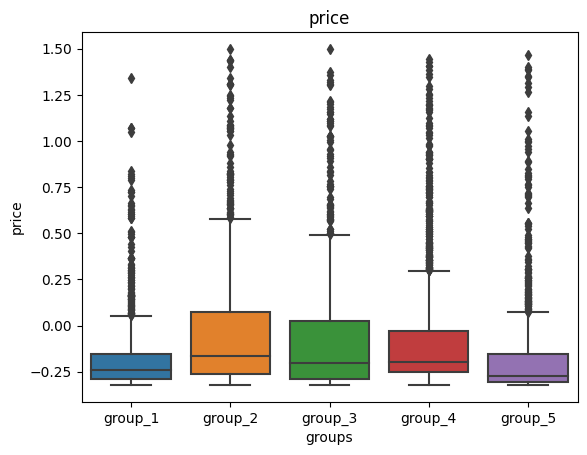

In [819]:
sns.boxplot(y=df_cluster_scaled['price'], x=df_cluster_tsne_price_drop['groups'], order = order)
    
plt.title('price')

plt.show()

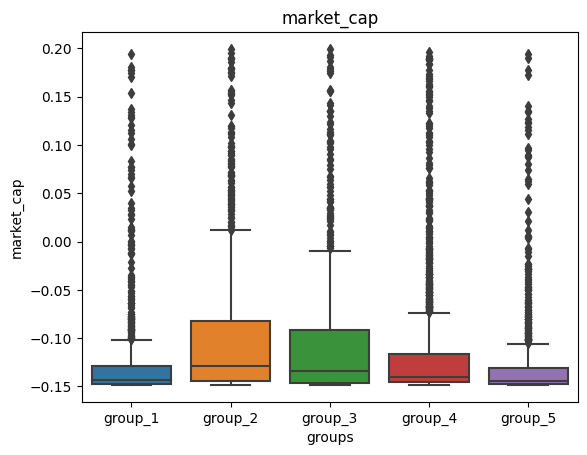

In [820]:
sns.boxplot(y=df_cluster_scaled['market_cap'], x=df_cluster_tsne_market_cap_drop['groups'], order = order)
    
plt.title('market_cap')

plt.show()

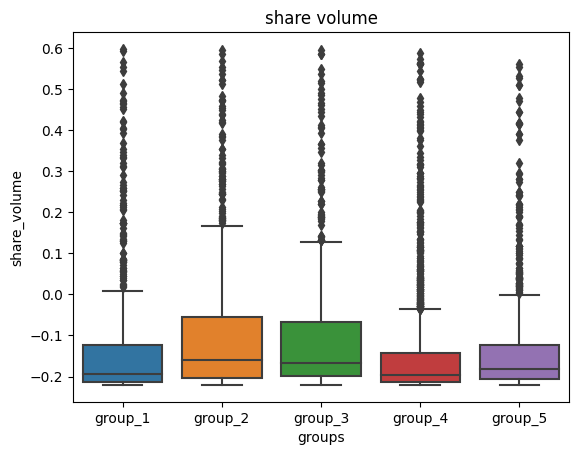

In [821]:
sns.boxplot(y=df_cluster_scaled['share_volume'], x=df_cluster_tsne_share_volume_drop['groups'], order = order)
    
plt.title('share volume')

plt.show()

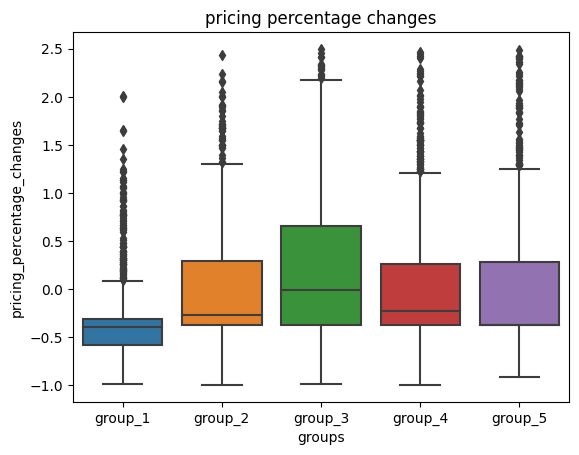

In [822]:
sns.boxplot(y=df_cluster_scaled['pricing_percentage_changes'], x=df_cluster_tsne_pricing_changes_drop2['groups'], order = order)
    
plt.title('pricing percentage changes')

plt.show()

#### Observations: ####
- Groups 2 and 3 have the highest values for price, market cap, and share volume. They perform slightly better than groups 4 and 5 in pricing percentage changes.

In [823]:
# Fitting t-SNE with number of components equal to 3 
tsne = TSNE(n_components = 3, random_state = 1)

df_cluster_tsne = tsne.fit_transform(df_cluster_scaled)

In [824]:
df_cluster_tsne = pd.DataFrame(df_cluster_tsne, columns = ['X1', 'X2', 'X3'])

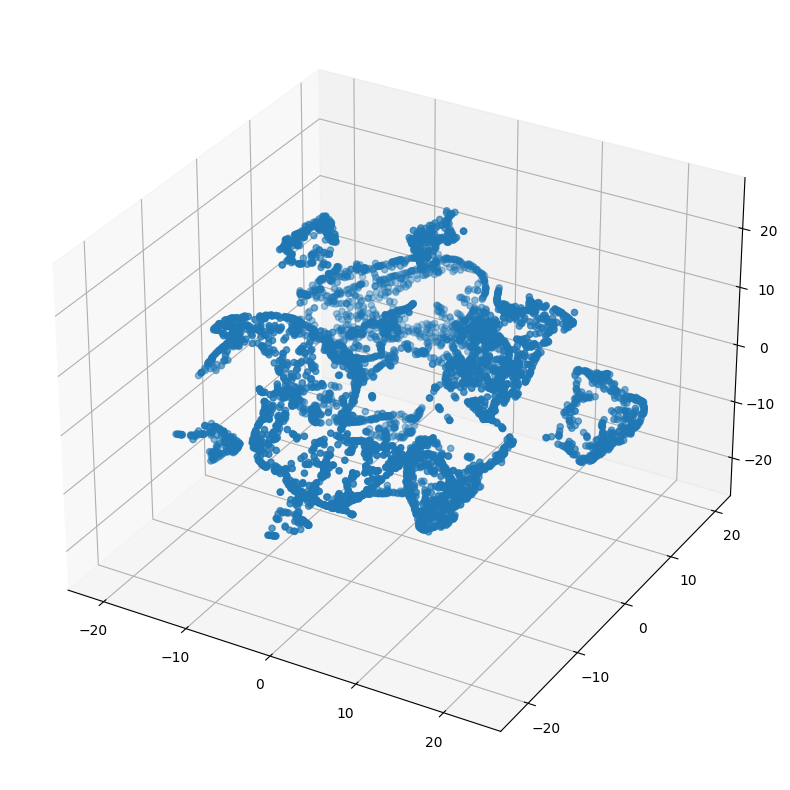

In [826]:
# Scatter plot for all three components
fig = plt.figure(figsize = (10, 10))

ax = fig.add_subplot(111, projection = '3d')

x = df_cluster_tsne['X1']

y = df_cluster_tsne['X2']

z = df_cluster_tsne['X3']

ax.scatter(x, y, z)

plt.show()

### Clustering ###

In [5]:
# Importing clustering algorithms
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture

from sklearn_extra.cluster import KMedoids

from sklearn.cluster import AgglomerativeClustering

from sklearn.cluster import DBSCAN

# Silhouette score
from sklearn.metrics import silhouette_score

In [28]:
df_cluster_with_symbol = df_cluster.copy()

In [21]:
# Scaling the data and storing the output as a new DataFrame

scaler = StandardScaler()

df_cluster_scaled = pd.DataFrame(scaler.fit_transform(df_cluster), columns = df_cluster.columns)

df_kmeans_scaled = df_cluster_scaled.copy()
df_kmed_scaled = df_cluster_scaled.copy()
df_gmm_scaled = df_cluster_scaled.copy()
df_hierarchical_scaled = df_cluster_scaled.copy()

In [22]:
# Creating copy of the data to store labels from each algorithm
df_kmeans_scaled_copy = df_kmeans_scaled.copy(deep = True)
df_kmed_scaled_copy = df_kmeans_scaled.copy(deep = True)
df_gmm_scaled_copy = df_kmeans_scaled.copy(deep = True)
df_hierarchical_scaled_copy = df_kmeans_scaled.copy(deep = True)

#### K-Means ###

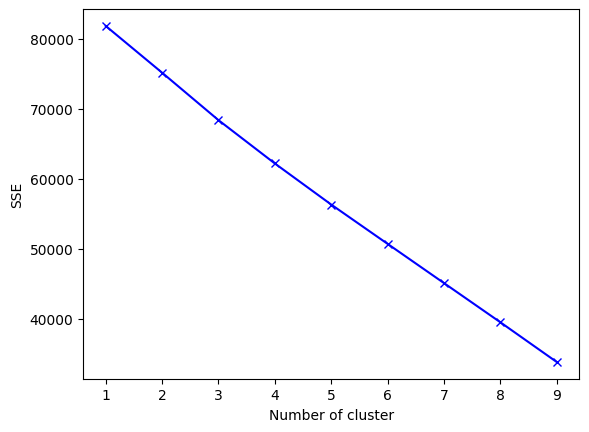

In [23]:
# Empty dictionary to store the SSE for each value of K
sse = {} 

# Iterate for a range of Ks and fit the scaled data to the algorithm. 
# Use inertia attribute from the clustering object and store the inertia value for that K 
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(df_kmeans_scaled)
    
    sse[k] = kmeans.inertia_

# Elbow plot
plt.figure()

plt.plot(list(sse.keys()), list(sse.values()), 'bx-')

plt.xlabel("Number of cluster")

plt.ylabel("SSE")

plt.show()

##### Observations #####
- There is no elbow in the curve
- We can try between 2 and 5 clusters
- Check Silhouette scores

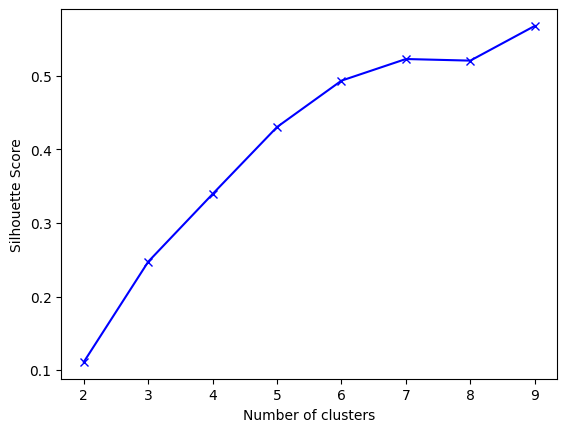

In [25]:
# Empty dictionary to store the Silhouette score for each value of K
sc = {} 

# Iterate for a range of Ks and fit the scaled data to the algorithm. Store the Silhouette score for that K 
for k in range(2, 10):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(df_kmeans_scaled)
    
    labels = kmeans.predict(df_kmeans_scaled)
    
    sc[k] = silhouette_score(df_kmeans_scaled, labels)

# Elbow plot
plt.figure()

plt.plot(list(sc.keys()), list(sc.values()), 'bx-')

plt.xlabel("Number of clusters")

plt.ylabel("Silhouette Score")

plt.show()

In [35]:
kmeans_2 = KMeans(n_clusters = 7, random_state = 1)

kmeans_2.fit(df_kmeans_scaled)

# Adding predicted labels to the original data and the scaled data 
df_kmeans_scaled_copy['KMeans_Labels_2'] = kmeans_2.predict(df_kmeans_scaled)

df_cluster_with_symbol['KMeans_Labels_2'] = kmeans_2.predict(df_kmeans_scaled)

In [36]:
df_cluster_with_symbol['KMeans_Labels_2'].value_counts()

1    1487
0    1078
2     845
3     780
4     661
5     438
6     166
Name: KMeans_Labels_2, dtype: int64

In [45]:
# Calculating the mean and the median of the original data for each label

mean = df_kmeans_scaled_copy.groupby('KMeans_Labels_2').mean()

median = df_kmeans_scaled_copy.groupby('KMeans_Labels_2').median()

df_kmeans_2 = pd.concat([mean, median], axis = 0)

df_kmeans_2.index = ['group_0 Mean', 'group_1 Mean','group_2 Mean', 'group_3 Mean','group_4 Mean', 'group_5 Mean','group_6 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median', 'group_3 Median', 'group_4 Median', 'group_5 Median', 'group_6 Median']

In [46]:
# Add colors to high abs value scores
def color_high(val):
    if val > 0.5:
        return 'background: skyblue'   
    
df_kmeans_2.T.style.applymap(color_high)

,group_0 Mean,group_1 Mean,group_2 Mean,group_3 Mean,group_4 Mean,group_5 Mean,group_6 Mean,group_0 Median,group_1 Median,group_2 Median,group_3 Median,group_4 Median,group_5 Median,group_6 Median
price,-0.099841,-0.051178,-0.007109,0.082335,0.083160,0.164794,-0.009834,-0.282256,-0.209000,-0.213007,-0.197416,-0.180004,-0.154249,-0.091134
market_cap,-0.053448,-0.069296,0.005812,0.167346,0.018569,0.005786,0.062712,-0.144610,-0.141255,-0.135496,-0.127288,-0.127510,-0.129578,-0.087327
share_volume,-0.098340,-0.110539,0.139329,0.120315,0.023022,0.079618,0.052486,-0.180457,-0.205750,-0.153081,-0.155187,-0.156615,-0.176450,-0.176149
pricing_percentage_changes,-0.051975,-0.106432,-0.034663,0.339848,0.003855,0.042566,-0.257170,-0.376074,-0.344834,-0.376074,-0.089529,-0.323963,-0.234284,-0.376074
sector_Capital Goods,-0.295471,-0.295471,-0.295471,-0.295471,-0.295471,3.384426,-0.295471,-0.295471,-0.295471,-0.295471,-0.295471,-0.295471,3.384426,-0.295471
sector_Consumer Durables,-0.168728,-0.168728,0.920515,-0.168728,-0.168728,-0.168728,-0.168728,-0.168728,-0.168728,-0.168728,-0.168728,-0.168728,-0.168728,-0.168728
sector_Consumer Non-Durables,-0.201577,-0.201577,1.099729,-0.201577,-0.201577,-0.201577,-0.201577,-0.201577,-0.201577,-0.201577,-0.201577,-0.201577,-0.201577,-0.201577
sector_Consumer Services,-0.371323,-0.371323,-0.371323,-0.371323,2.693074,-0.371323,-0.371323,-0.371323,-0.371323,-0.371323,-0.371323,2.693074,-0.371323,-0.371323
sector_Energy,-0.196097,-0.196097,1.069834,-0.196097,-0.196097,-0.196097,-0.196097,-0.196097,-0.196097,-0.196097,-0.196097,-0.196097,-0.196097,-0.196097
sector_Finance,-0.556528,1.483491,-0.556528,-0.553511,-0.556528,-0.556528,-0.556528,-0.556528,1.796853,-0.556528,-0.556528,-0.556528,-0.556528,-0.556528


#### Observations: ####
- Group 2 contains a diverse sector portfolio with high average share volume.
- Group 3 consists primarily of technology stocks and has the highest pricing percentage change.
- Group 5 consists primarily of capital goods stocks and has a positive pricing percentage change on average.

In [48]:
kmeans_3 = KMeans(n_clusters = 3, random_state = 1)

kmeans_3.fit(df_kmeans_scaled)

# Adding predicted labels to the original data and the scaled data 
df_kmeans_scaled_copy['KMeans_Labels_3'] = kmeans_3.predict(df_kmeans_scaled)

df_cluster_with_symbol['KMeans_Labels_3'] = kmeans_3.predict(df_kmeans_scaled)

In [49]:
df_cluster_with_symbol['KMeans_Labels_3'].value_counts()

2    3088
1    1289
0    1078
Name: KMeans_Labels_3, dtype: int64

In [53]:
# Calculating the mean and the median of the original data for each label
mean = df_kmeans_scaled_copy.groupby('KMeans_Labels_3').mean()

median = df_kmeans_scaled_copy.groupby('KMeans_Labels_3').median()

df_kmeans_3 = pd.concat([mean, median], axis = 0)

df_kmeans_3.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']

# Add colors to high abs value scores
def color_high(val):
    if val > 0.1:
        return 'background: skyblue'  
    elif val > 0:
        return 'background: pink'
    
df_kmeans_3.T.style.applymap(color_high)

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
price,-0.099841,-0.062902,0.061110,-0.282256,-0.214683,-0.183221
market_cap,-0.053448,-0.076161,0.050450,-0.144610,-0.141944,-0.128564
share_volume,-0.098340,-0.122573,0.085494,-0.180457,-0.208537,-0.158893
pricing_percentage_changes,-0.051975,-0.111313,0.064609,-0.376074,-0.344834,-0.292983
sector_Capital Goods,-0.295471,-0.295471,0.226483,-0.295471,-0.295471,-0.295471
sector_Consumer Durables,-0.168728,-0.168728,0.129333,-0.168728,-0.168728,-0.168728
sector_Consumer Non-Durables,-0.201577,-0.201577,0.154512,-0.201577,-0.201577,-0.201577
sector_Consumer Services,-0.371323,-0.371323,0.284625,-0.371323,-0.371323,-0.371323
sector_Energy,-0.196097,-0.196097,0.150312,-0.196097,-0.196097,-0.196097
sector_Finance,-0.556528,1.796853,-0.555766,-0.556528,1.796853,-0.556528


#### Observations: ####
- Group 2 has a very diverse basket of stocks and has the best market results on average.

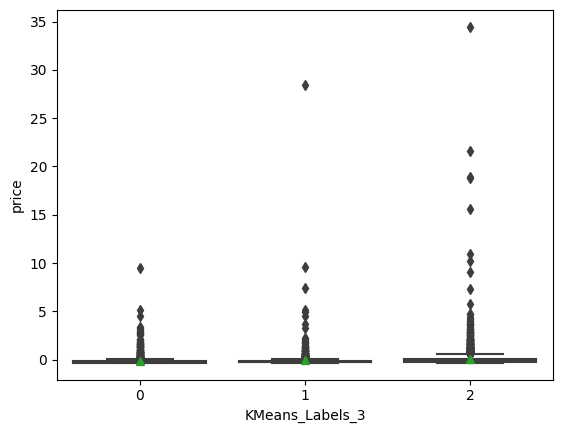

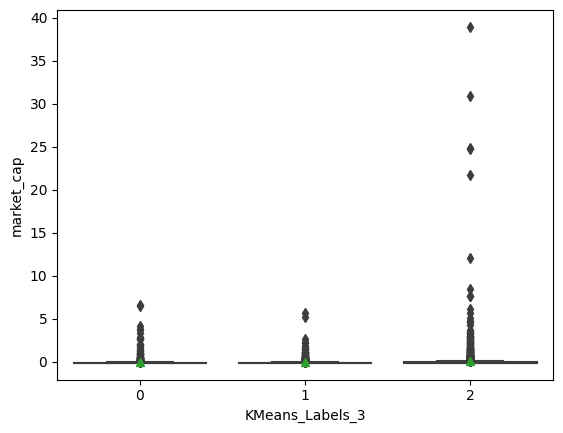

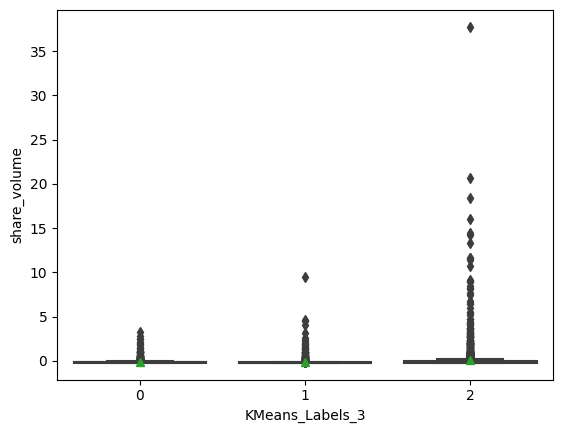

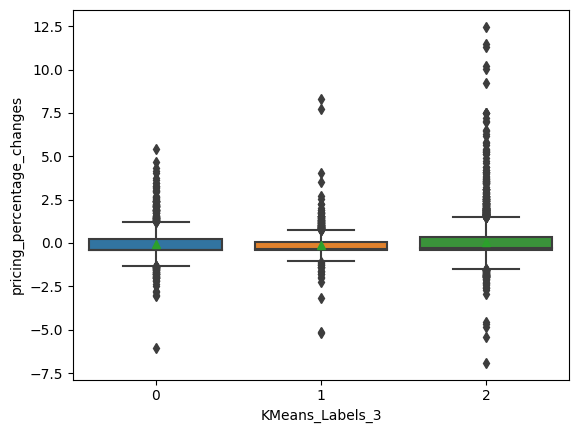

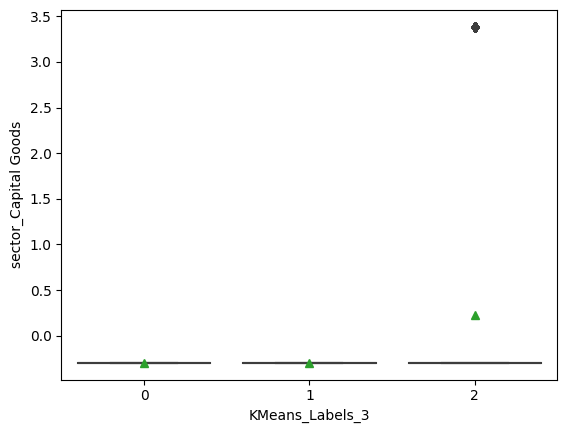

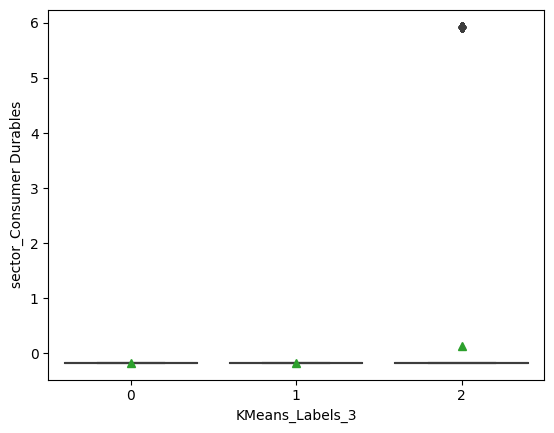

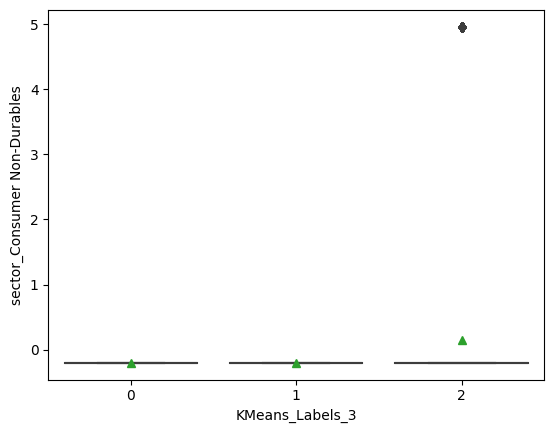

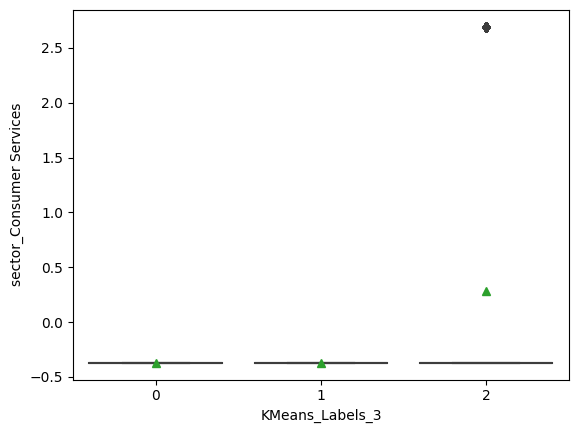

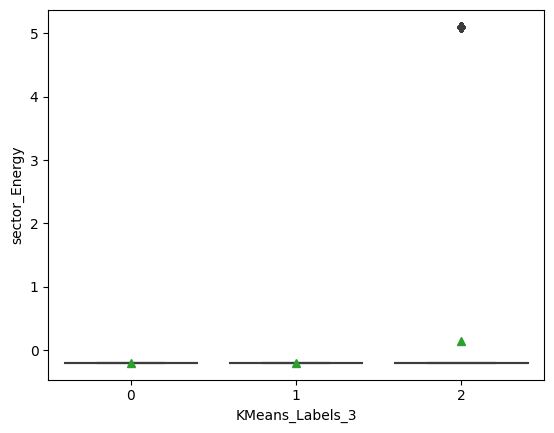

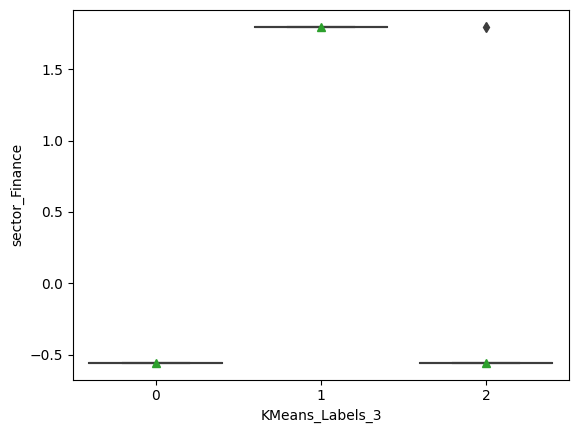

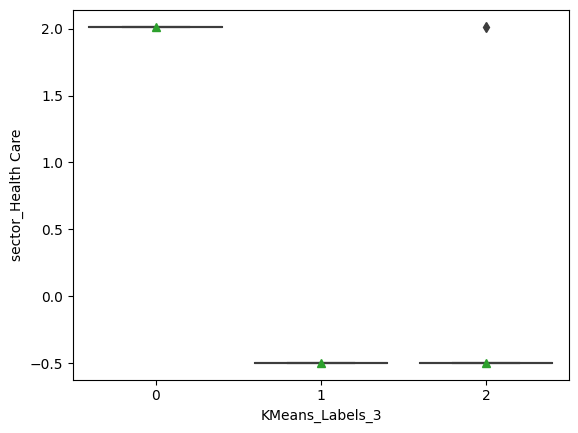

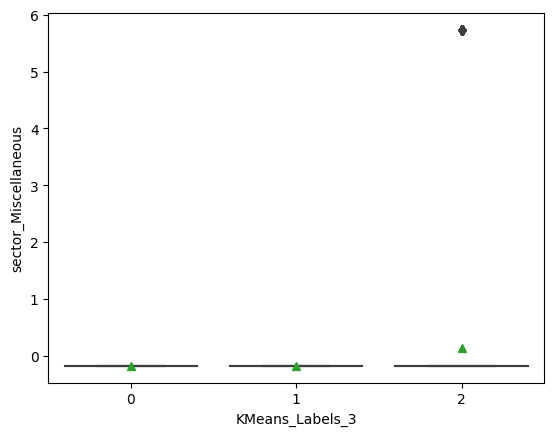

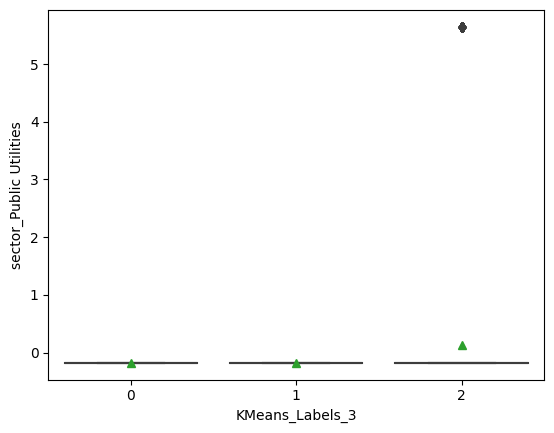

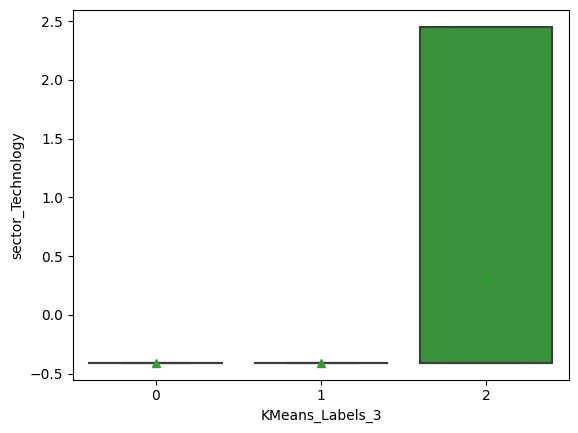

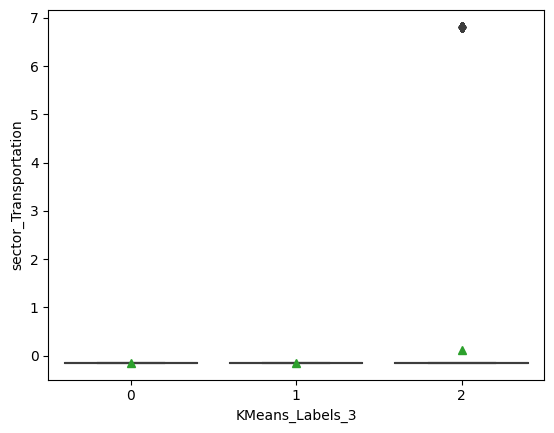

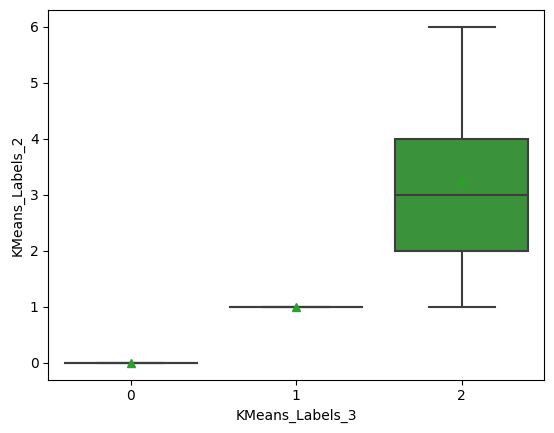

In [51]:
# Visualizing features by cluster

#cols_visualise = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

for col in df_kmeans_3.columns:
    sns.boxplot(x = 'KMeans_Labels_3', y = col, data = df_kmeans_scaled_copy, showmeans=True)
    plt.show()

We can run the grouped data for each feature against percentage_change to see if there is correlation.

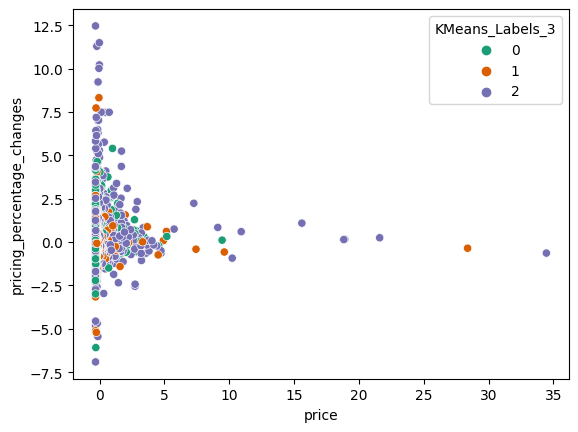

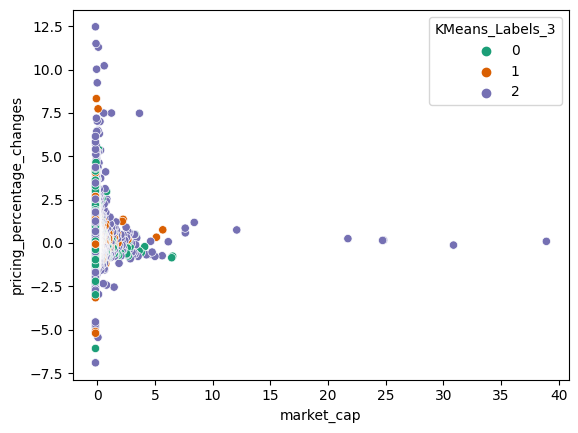

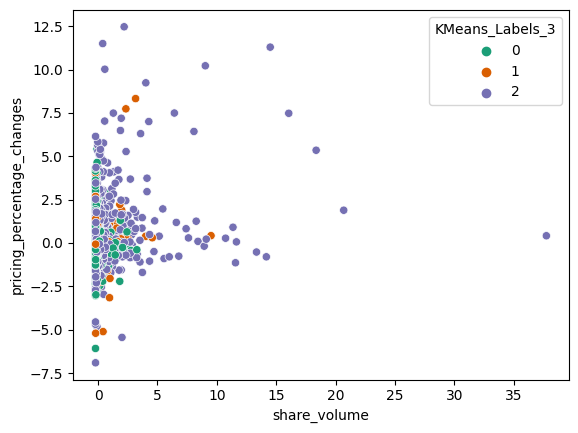

In [57]:
cols = ['price','market_cap','share_volume']

for col in cols:
    sns.scatterplot(x = col, y = 'pricing_percentage_changes', data = df_kmeans_scaled_copy, hue = 'KMeans_Labels_3', palette = 'Dark2')
    
    plt.show()

#### K-Medoids Clustering ####

In [58]:
kmedo = KMedoids(n_clusters = 3, random_state = 1)

kmedo.fit(df_kmed_scaled)

df_kmed_scaled_copy['kmedoLabels'] = kmedo.predict(df_kmed_scaled)

df_cluster_with_symbol['kmedoLabels'] = kmedo.predict(df_kmed_scaled)

df_kmed_scaled_copy.head()

,price,market_cap,share_volume,pricing_percentage_changes,sector_Capital Goods,sector_Consumer Durables,sector_Consumer Non-Durables,sector_Consumer Services,sector_Energy,sector_Finance,sector_Health Care,sector_Miscellaneous,sector_Public Utilities,sector_Technology,sector_Transportation,kmedoLabels
0,0.825037,38.941903,8.409947,0.093820,-0.295471,-0.168728,-0.201577,-0.371323,-0.196097,-0.556528,-0.49656,-0.17439,-0.177161,2.451850,-0.14675,0
1,1.787093,30.890552,2.880491,-0.121525,-0.295471,-0.168728,-0.201577,-0.371323,-0.196097,-0.556528,-0.49656,-0.17439,-0.177161,2.451850,-0.14675,0
2,18.909542,24.827214,-0.097917,0.163191,-0.295471,-0.168728,-0.201577,-0.371323,-0.196097,-0.556528,-0.49656,-0.17439,-0.177161,2.451850,-0.14675,0
3,18.831258,24.743846,-0.083232,0.148003,-0.295471,-0.168728,-0.201577,-0.371323,-0.196097,-0.556528,-0.49656,-0.17439,-0.177161,2.451850,-0.14675,0
4,21.600202,21.736236,0.136541,0.251445,-0.295471,-0.168728,-0.201577,2.693074,-0.196097,-0.556528,-0.49656,-0.17439,-0.177161,-0.407855,-0.14675,0


In [59]:
df_kmed_scaled_copy.kmedoLabels.value_counts()

1    3194
2    1280
0     981
Name: kmedoLabels, dtype: int64

In [62]:
# Calculating the mean and the median of the original data for each label

mean = df_kmed_scaled_copy.groupby('kmedoLabels').mean()

median = df_kmed_scaled_copy.groupby('kmedoLabels').median()

df_kmedoids = pd.concat([mean, median], axis = 0)

df_kmedoids.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']

# Add colors to high abs value scores
def color_high(val):
    if val > 0.5:
        return 'background: skyblue'  
    elif val > 0.1:
        return 'background: pink'
    
df_kmedoids.T.style.applymap(color_high)

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
price,0.295061,-0.056731,-0.084575,-0.125799,-0.232278,-0.214683
market_cap,0.213789,-0.035164,-0.076105,-0.097013,-0.138812,-0.141971
share_volume,0.333485,-0.050372,-0.129891,-0.140980,-0.170533,-0.208553
pricing_percentage_changes,1.420390,-0.381135,-0.137544,0.979704,-0.376074,-0.344993
sector_Capital Goods,0.090899,0.090492,-0.295471,-0.295471,-0.295471,-0.295471
sector_Consumer Durables,-0.025818,0.075547,-0.168728,-0.168728,-0.168728,-0.168728
sector_Consumer Non-Durables,0.151007,0.034402,-0.201577,-0.201577,-0.201577,-0.201577
sector_Consumer Services,0.066002,0.128536,-0.371323,-0.371323,-0.371323,-0.371323
sector_Energy,-0.136718,0.120578,-0.196097,-0.196097,-0.196097,-0.196097
sector_Finance,-0.532539,-0.556528,1.796853,-0.556528,-0.556528,1.796853


#### Observations: ####
- Group 0 contains about 20% of the stocks mostly in Consumer Non-Durables, Technology, and Transportation and has a very high positive pricing percentage change on average.

In [63]:
def remove_outliers(data, feature, direction, cutoffs_list, cluster_labels):
    if direction == 'less':
        index = data[(data[feature] > cutoffs_list[0])].index
        data_drop = data.drop(index , axis=0)
    elif direction == 'greater':
        index = data[(data[feature] < cutoffs_list[0])].index
        data_drop = data.drop(index , axis=0)
    elif direction == 'both':
        index_less = data[(data[feature] > cutoffs_list[0])].index
        data_drop1 = data.drop(index_less , axis=0)
        index_greater = data[(data[feature] < cutoffs_list[1])].index
        data_drop = data_drop1.drop(index_greater , axis=0)
    else:
        return print('choose less, greater, or both as direction')

    
    sns.boxplot(y=data_drop[feature], x=cluster_labels, data = data)
    
    plt.title(feature)

    plt.show()

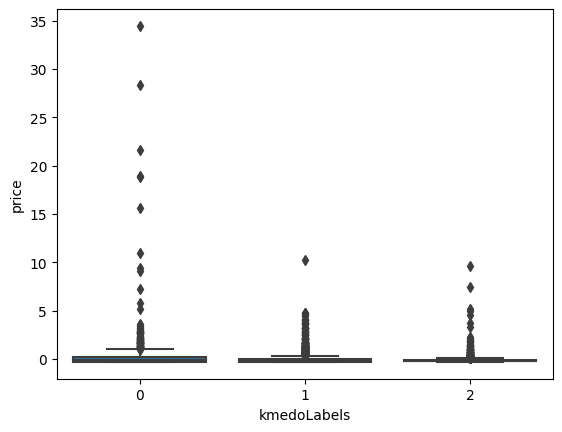

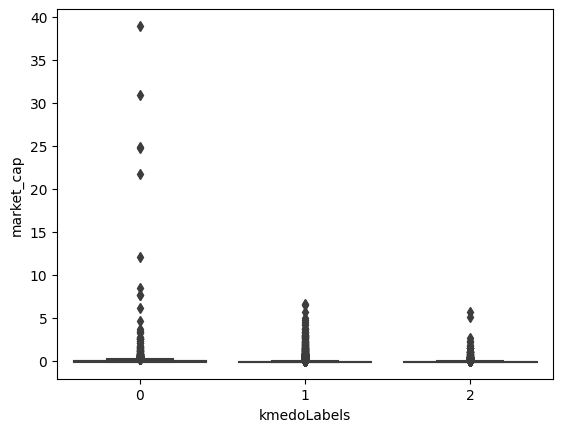

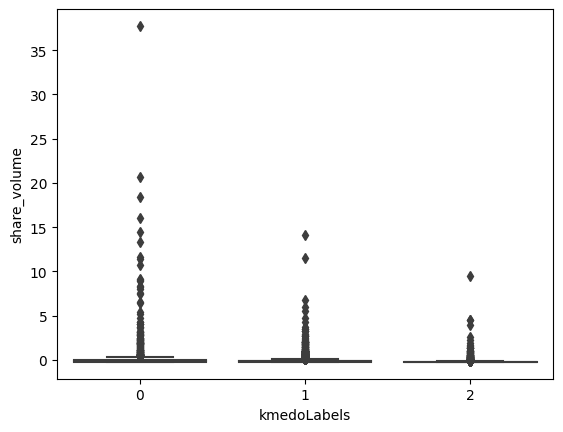

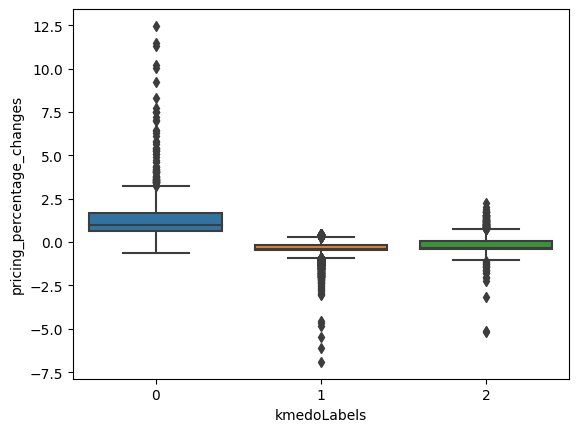

In [65]:
cols = ['price','market_cap','share_volume','pricing_percentage_changes']

for col in cols:
    sns.boxplot(x = 'kmedoLabels', y = col, data = df_kmed_scaled_copy)
    
    plt.show()

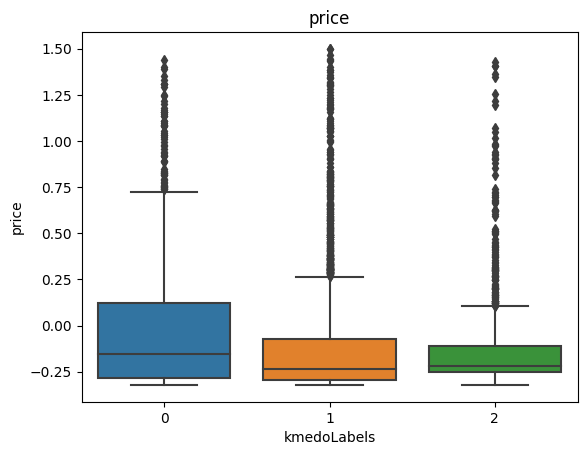

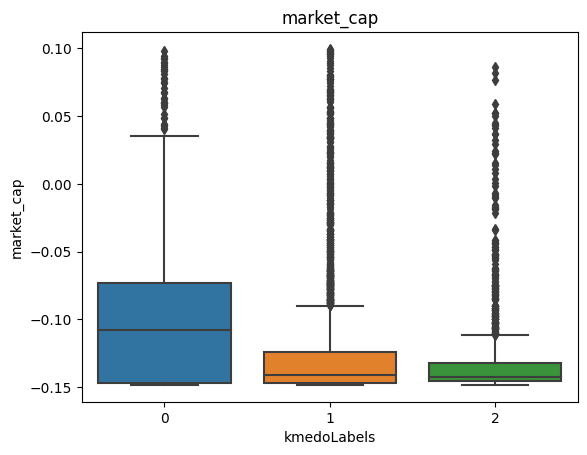

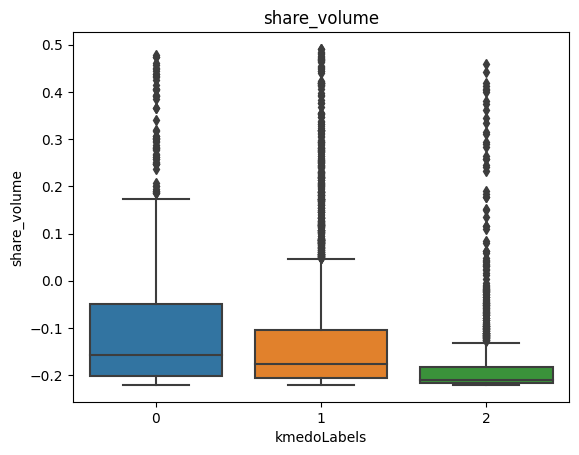

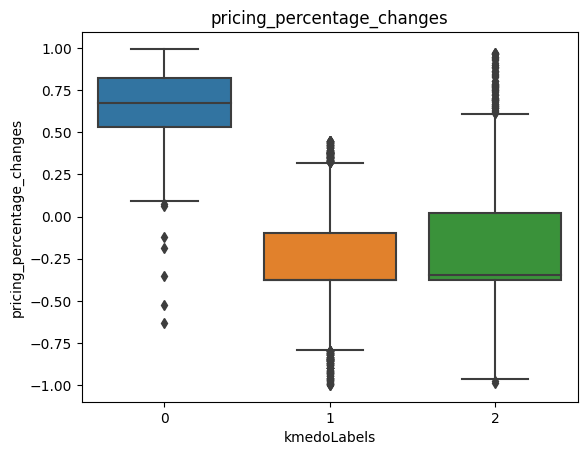

In [67]:
# Removing outliers to get more expressive boxplots

remove_outliers(df_kmed_scaled_copy, 'price', 'less', [1.5], 'kmedoLabels') 

remove_outliers(df_kmed_scaled_copy, 'market_cap', 'less', [0.1], 'kmedoLabels')

remove_outliers(df_kmed_scaled_copy, 'share_volume', 'less', [0.5], 'kmedoLabels')

remove_outliers(df_kmed_scaled_copy, 'pricing_percentage_changes', 'both', [1,-1], 'kmedoLabels')

#### Gaussian Mixture Model ####

In [69]:
gmm = GaussianMixture(n_components = 3, random_state = 1)

gmm.fit(df_gmm_scaled)

df_gmm_scaled_copy['GmmLabels'] = gmm.predict(df_gmm_scaled)

df_cluster_with_symbol['GmmLabels'] = gmm.predict(df_gmm_scaled)

In [71]:
df_cluster_with_symbol.GmmLabels.value_counts()

2    3087
1    1290
0    1078
Name: GmmLabels, dtype: int64

In [72]:
# Calculating the mean and the median of the original data for each label

mean = df_gmm_scaled_copy.groupby('GmmLabels').mean()

median = df_gmm_scaled_copy.groupby('GmmLabels').median()

df_gmm = pd.concat([mean, median], axis = 0)

df_gmm.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']

df_gmm.T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
price,-0.099841,-0.063020,0.061200,-0.282256,-0.215011,-0.183209
market_cap,-0.053448,-0.076024,0.050433,-0.144610,-0.141935,-0.128591
share_volume,-0.098340,-0.111243,0.080827,-0.180457,-0.208465,-0.158899
pricing_percentage_changes,-0.051975,-0.102472,0.060971,-0.376074,-0.344818,-0.293303
sector_Capital Goods,-0.295471,-0.295471,0.226652,-0.295471,-0.295471,-0.295471
sector_Consumer Durables,-0.168728,-0.168728,0.129429,-0.168728,-0.168728,-0.168728
sector_Consumer Non-Durables,-0.201577,-0.201577,0.154627,-0.201577,-0.201577,-0.201577
sector_Consumer Services,-0.371323,-0.371323,0.284837,-0.371323,-0.371323,-0.371323
sector_Energy,-0.196097,-0.196097,0.150424,-0.196097,-0.196097,-0.196097
sector_Finance,-0.556528,1.796853,-0.556528,-0.556528,1.796853,-0.556528


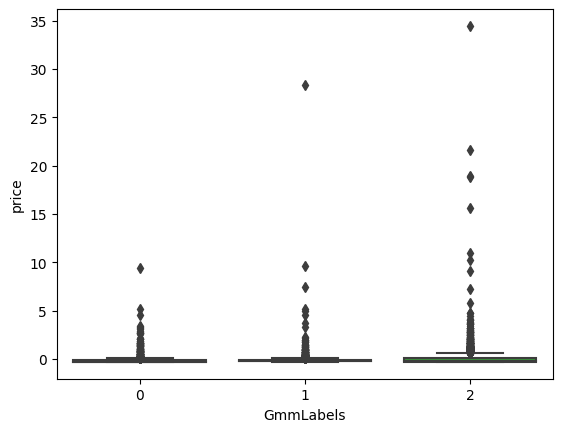

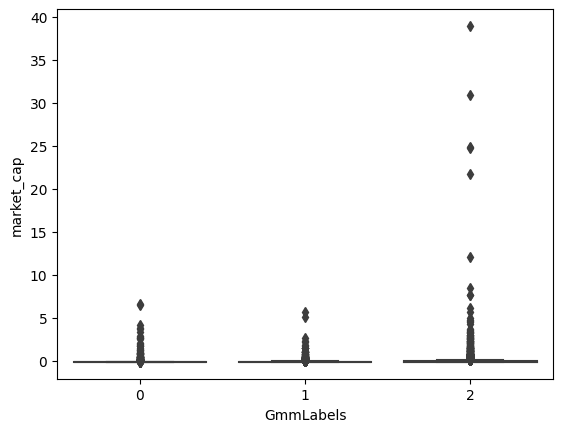

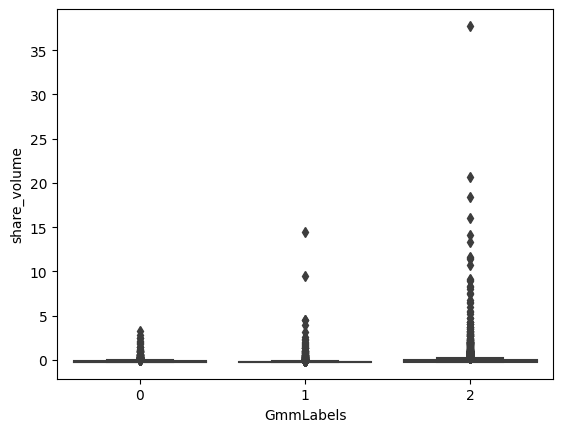

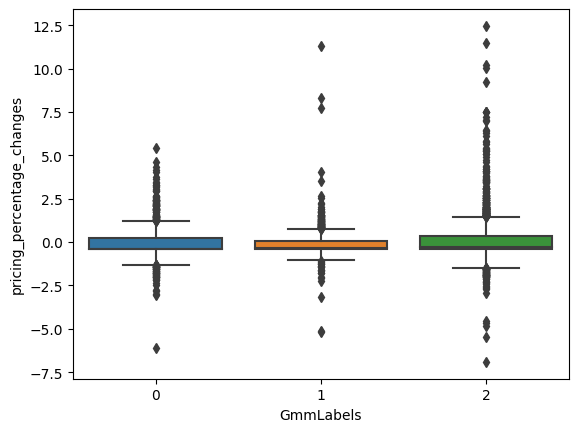

In [74]:
cols = ['price','market_cap','share_volume','pricing_percentage_changes']

for col in cols:
    sns.boxplot(x = 'GmmLabels', y = col, data = df_gmm_scaled_copy)
    
    plt.show()

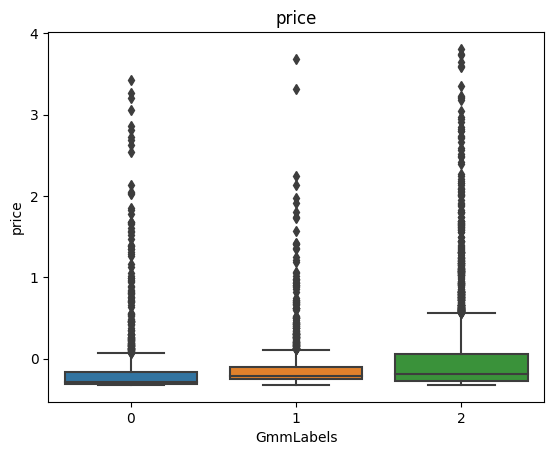

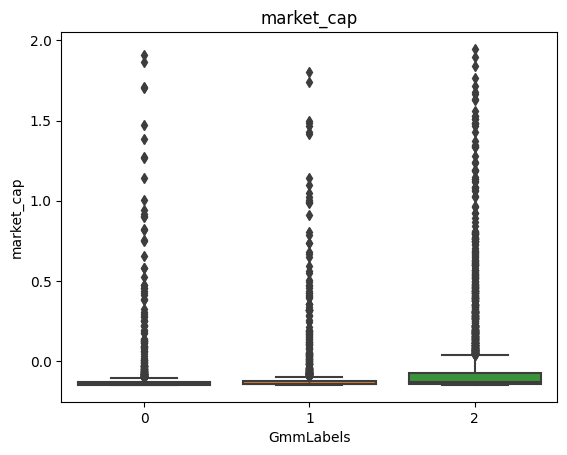

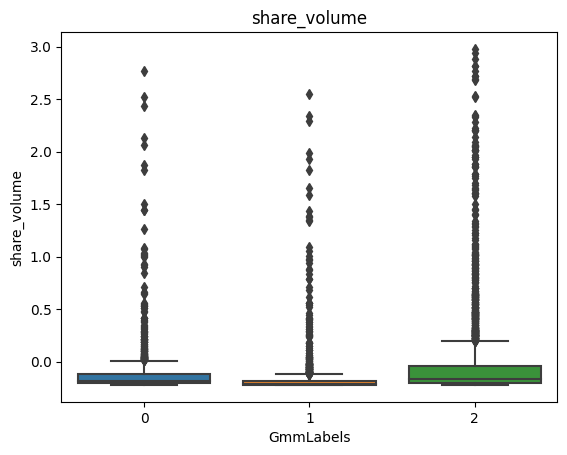

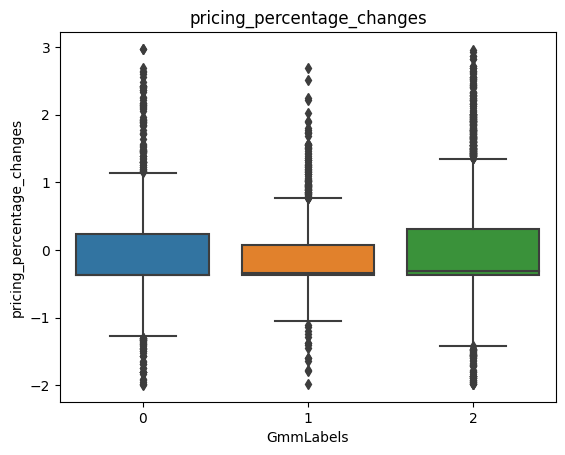

In [75]:
# Removing outliers to get more expressive boxplots

remove_outliers(df_gmm_scaled_copy, 'price', 'less', [4], 'GmmLabels') 

remove_outliers(df_gmm_scaled_copy, 'market_cap', 'less', [2], 'GmmLabels')

remove_outliers(df_gmm_scaled_copy, 'share_volume', 'less', [3], 'GmmLabels')

remove_outliers(df_gmm_scaled_copy, 'pricing_percentage_changes', 'both', [3,-2], 'GmmLabels')

### Hierarchical Clustering ###

In [76]:
from scipy.cluster.hierarchy import dendrogram, linkage

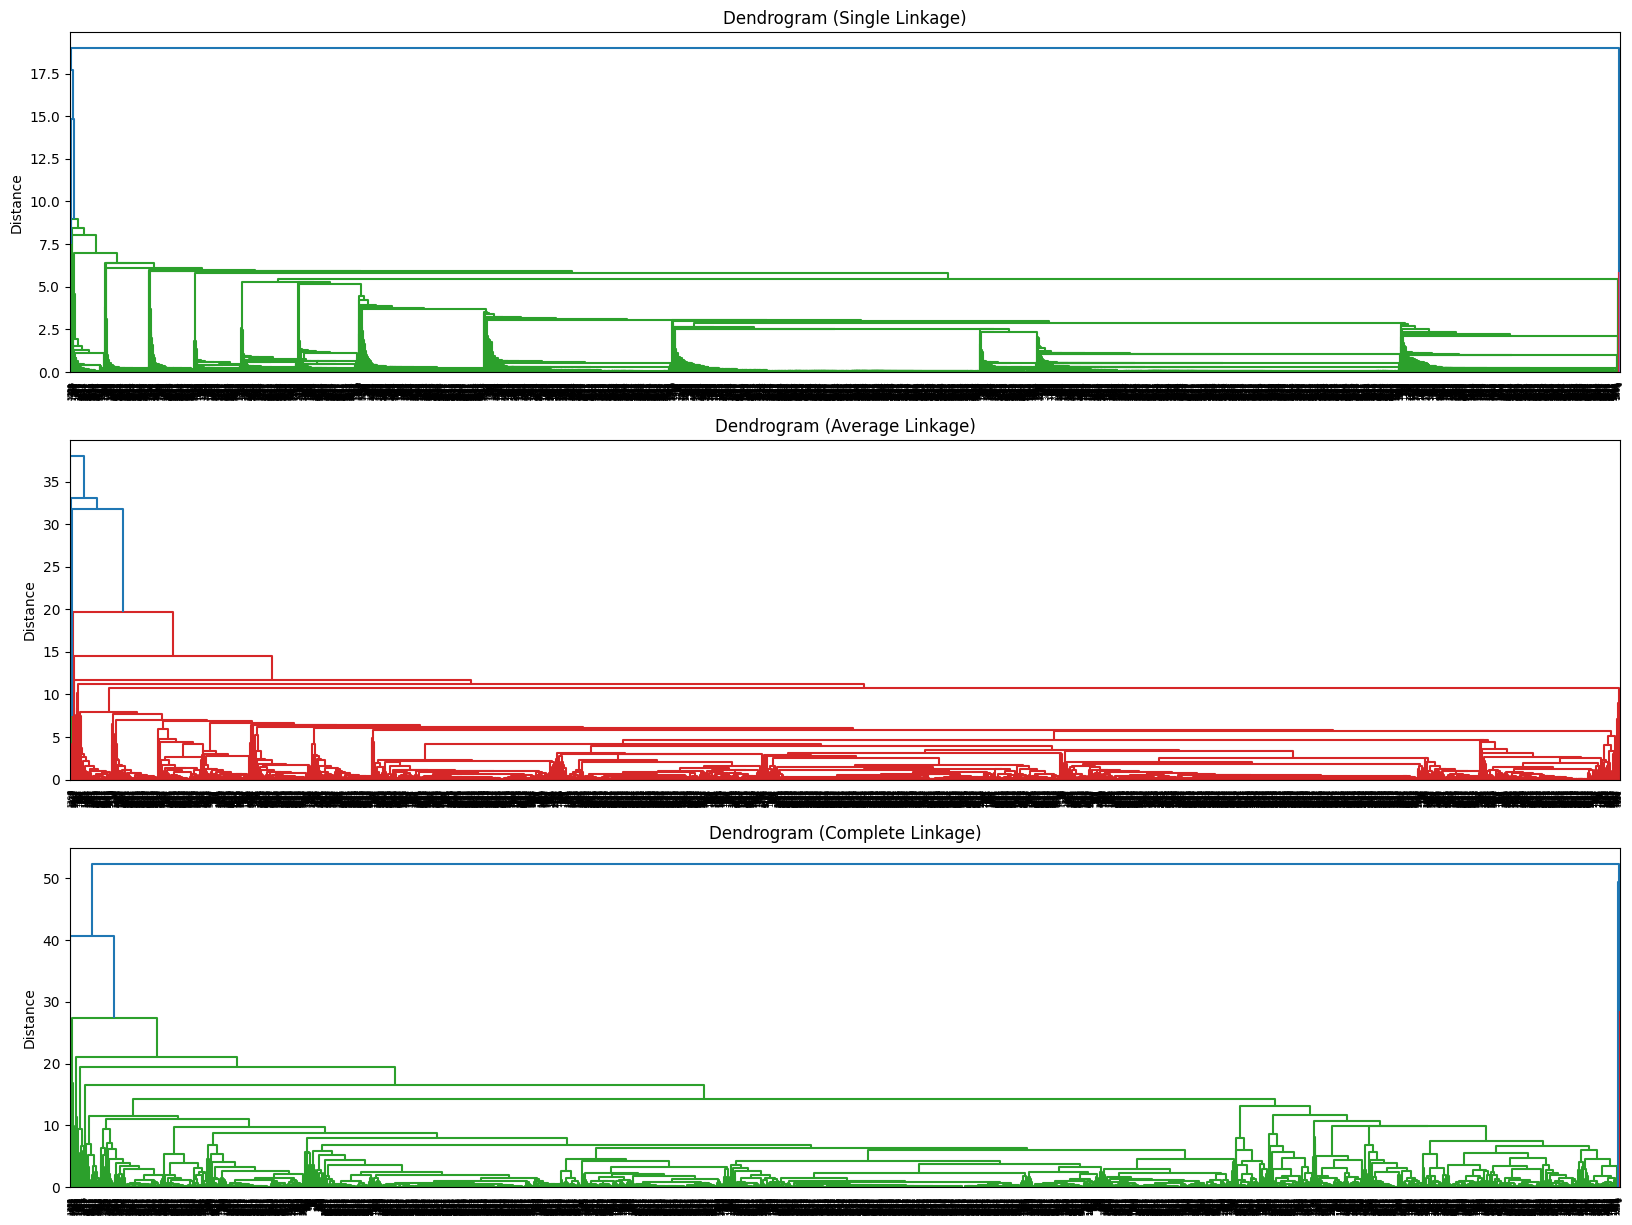

In [77]:
# The List of all linkage methods to check
methods = ['single',
           'average', 
           'complete']

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize = (20, 15))

# Enumerate through the list of all methods above, get linkage and plot dendrogram
for i, method in enumerate(methods):
    Z = linkage(df_hierarchical_scaled_copy, metric = 'euclidean', method = method)
    
    dendrogram(Z, ax = axs[i]);
    
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    
    axs[i].set_ylabel('Distance')

#### Observations: ####
- Complete linkage seems to have the best clustering.
- Taking the threshold to be about 30 gives 4 clusters.

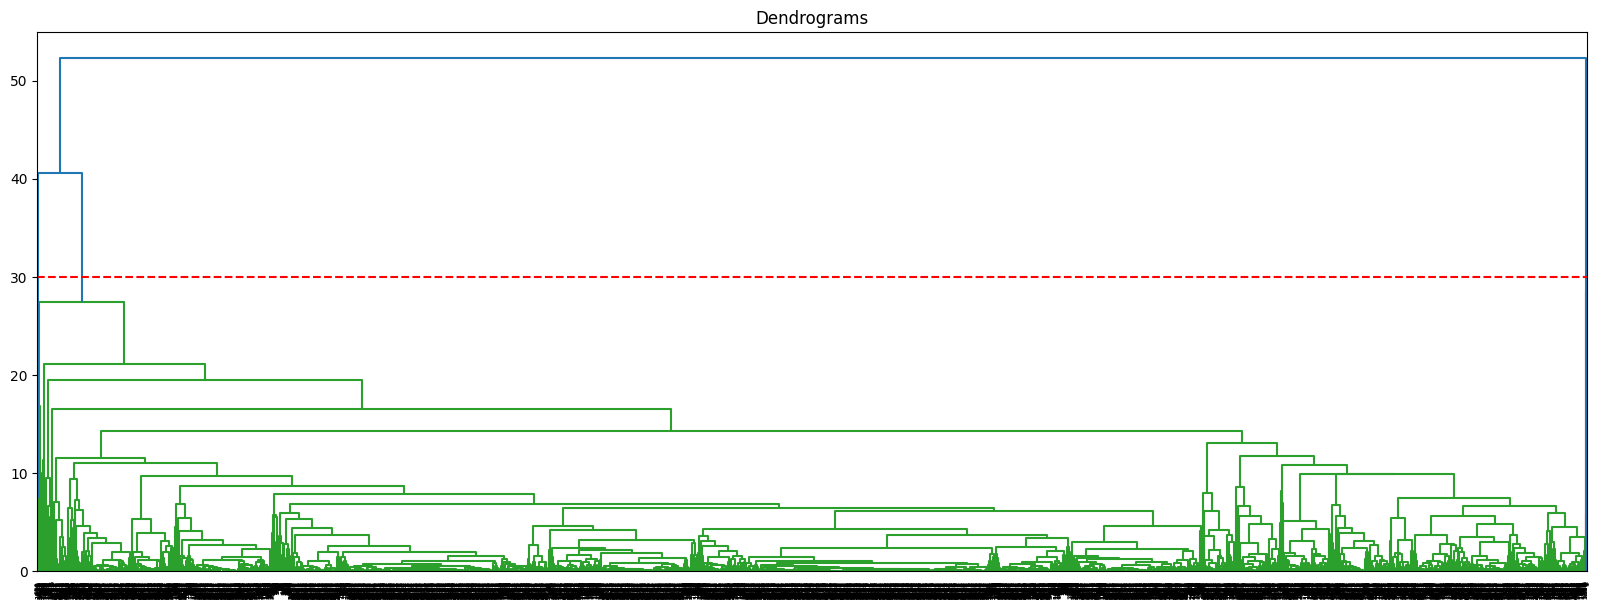

In [78]:
plt.figure(figsize = (20, 7))  

plt.title("Dendrograms")  

dend = dendrogram(linkage(df_hierarchical_scaled_copy, method = 'complete'))

plt.axhline(y = 30, color = 'r', linestyle = '--')

In [79]:
# Clustering with 4 clusters and complete linkage
hierarchical_complete = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'complete')

hierarchical_complete.fit(df_hierarchical_scaled_copy)

AgglomerativeClustering(affinity='euclidean', linkage='complete', n_clusters=4)

In [80]:
df_hierarchical_scaled_copy['HCLabels_complete'] = hierarchical_complete.labels_
df_cluster_with_symbol['HCLabels_complete'] = hierarchical_complete.labels_

In [81]:
df_hierarchical_scaled_copy.HCLabels_complete.value_counts()

1    5447
0       5
3       2
2       1
Name: HCLabels_complete, dtype: int64

In [82]:
# Clustering with 4 clusters and average linkage
hierarchical_average = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'average')

hierarchical_average.fit(df_hierarchical_scaled_copy)

AgglomerativeClustering(affinity='euclidean', linkage='average', n_clusters=4)

In [83]:
df_hierarchical_scaled_copy['HCLabels_average'] = hierarchical_average.labels_
df_cluster_with_symbol['HCLabels_average'] = hierarchical_average.labels_

In [84]:
df_hierarchical_scaled_copy.HCLabels_average.value_counts()

2    5447
0       5
1       2
3       1
Name: HCLabels_average, dtype: int64

#### Observations: ####
- Very unevenly distributed
- We can look at the stocks in Groups 0-2

In [85]:
# Checking symbols in cluster 0
df_cluster_with_symbol[df_cluster_with_symbol.HCLabels_average == 0]

# NEED TO PUT SYMBOLS BACK IN THIS DF

,price,market_cap,share_volume,pricing_percentage_changes,sector_Capital Goods,sector_Consumer Durables,sector_Consumer Non-Durables,sector_Consumer Services,sector_Energy,sector_Finance,...,sector_Miscellaneous,sector_Public Utilities,sector_Technology,sector_Transportation,KMeans_Labels_2,KMeans_Labels_3,kmedoLabels,GmmLabels,HCLabels_complete,HCLabels_average
0,157.510,2.699424e+12,63429579.0,0.015364,0,0,0,0,0,0,...,0,0,1,0,3,2,0,2,0,0
1,289.560,2.143429e+12,22790662.0,0.008323,0,0,0,0,0,0,...,0,0,1,0,3,2,0,2,0,0
2,2639.755,1.724719e+12,900760.0,0.017632,0,0,0,0,0,0,...,0,0,1,0,3,2,0,2,0,0
3,2629.010,1.718962e+12,1008687.0,0.017136,0,0,0,0,0,0,...,0,0,1,0,3,2,0,2,0,0
4,3009.070,1.511268e+12,2623915.0,0.020518,0,0,0,1,0,0,...,0,0,0,0,4,2,0,2,0,0


In [86]:
# Checking symbols in cluster 1
df_cluster_with_symbol[df_cluster_with_symbol.HCLabels_average == 1]

,price,market_cap,share_volume,pricing_percentage_changes,sector_Capital Goods,sector_Consumer Durables,sector_Consumer Non-Durables,sector_Consumer Services,sector_Energy,sector_Finance,...,sector_Miscellaneous,sector_Public Utilities,sector_Technology,sector_Transportation,KMeans_Labels_2,KMeans_Labels_3,kmedoLabels,GmmLabels,HCLabels_complete,HCLabels_average
592,4773.73,1.607471e+10,14971.0,-0.008354,1,0,0,0,0,0,...,0,0,0,0,5,2,0,2,3,1
1307,3939.99,4.593812e+09,250.0,0.000817,0,0,0,0,0,1,...,0,0,0,0,1,1,0,1,3,1


In [88]:
# Checking symbols in cluster 3
df_cluster_with_symbol[df_cluster_with_symbol.HCLabels_average == 3]

,price,market_cap,share_volume,pricing_percentage_changes,sector_Capital Goods,sector_Consumer Durables,sector_Consumer Non-Durables,sector_Consumer Services,sector_Energy,sector_Finance,...,sector_Miscellaneous,sector_Public Utilities,sector_Technology,sector_Transportation,KMeans_Labels_2,KMeans_Labels_3,kmedoLabels,GmmLabels,HCLabels_complete,HCLabels_average
6395,0.5287,31029078.0,279021147.0,0.025913,0,0,0,0,0,0,...,0,0,0,0,2,2,0,2,2,3


#### Observations: ####
- Clusters 0 and 1 consist of a few high priced stocks with mostly positive performance.

In [89]:
# Calculating the mean and the median of the original data for each label

mean = df_hierarchical_scaled_copy.groupby('HCLabels_average').mean()

median = df_hierarchical_scaled_copy.groupby('HCLabels_average').median()

df_hierachical_average = pd.concat([mean, median], axis = 0)

df_hierachical_average.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_3 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median', 'group_3 Median']

df_hierachical_average.T

,group_0 Mean,group_1 Mean,group_2 Mean,group_3 Mean,group_0 Median,group_1 Median,group_2 Median,group_3 Median
price,12.390626,31.419585,-0.022852,-0.318657,18.831258,31.419585,-0.214756,-0.318657
market_cap,28.227950,0.001241,-0.025885,-0.147960,24.827214,0.001241,-0.138299,-0.147960
share_volume,2.249166,-0.219441,-0.008913,37.743999,0.136541,-0.219441,-0.180149,37.743999
pricing_percentage_changes,0.106987,-0.491326,0.000006,0.416435,0.148003,-0.491326,-0.344802,0.416435
sector_Capital Goods,-0.295471,1.544477,-0.000242,-0.295471,-0.295471,1.544477,-0.295471,-0.295471
sector_Consumer Durables,-0.168728,-0.168728,0.000248,-0.168728,-0.168728,-0.168728,-0.168728,-0.168728
sector_Consumer Non-Durables,-0.201577,-0.201577,0.000296,-0.201577,-0.201577,-0.201577,-0.201577,-0.201577
sector_Consumer Services,0.241556,-0.371323,-0.000017,-0.371323,-0.371323,-0.371323,-0.371323,-0.371323
sector_Energy,-0.196097,-0.196097,0.000288,-0.196097,-0.196097,-0.196097,-0.196097,-0.196097
sector_Finance,-0.556528,0.620162,0.000385,-0.556528,-0.556528,0.620162,-0.556528,-0.556528


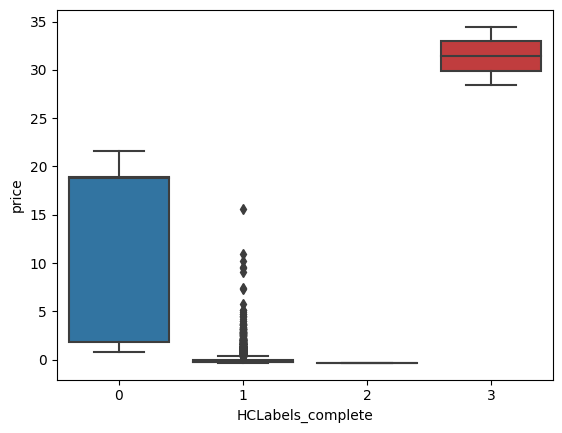

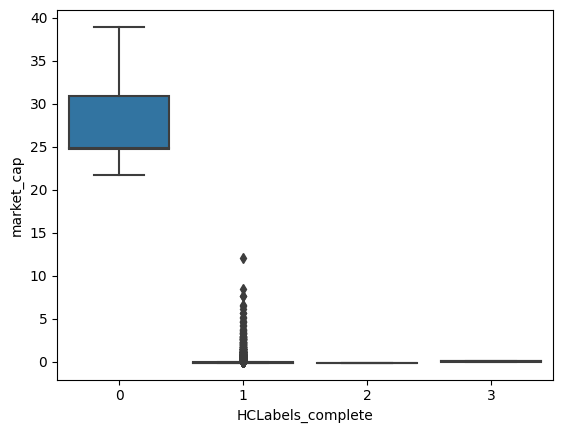

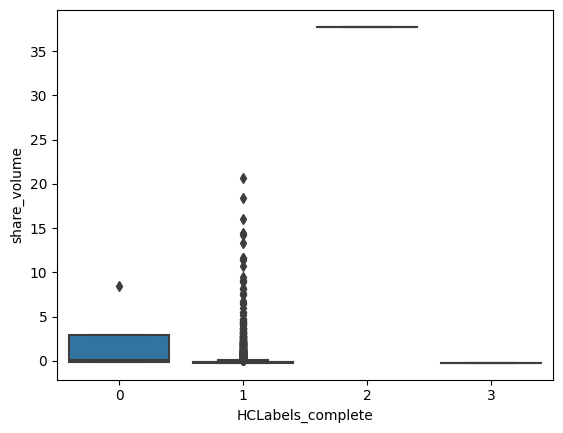

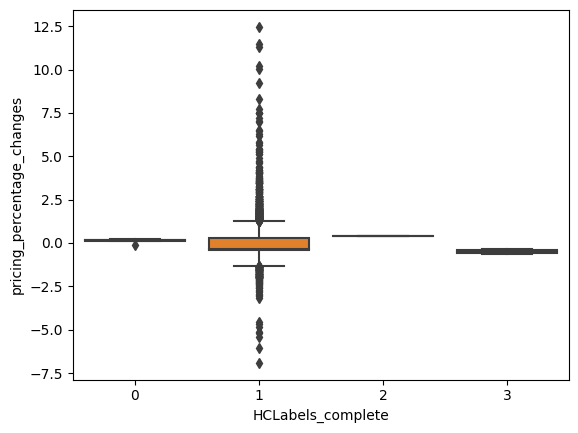

In [93]:
cols = ['price','market_cap','share_volume','pricing_percentage_changes']

for col in cols:
    sns.boxplot(x = 'HCLabels_complete', y = col, data = df_hierarchical_scaled_copy)
    plt.show()

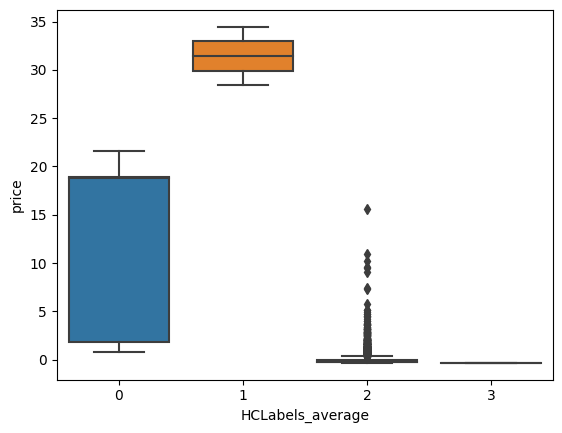

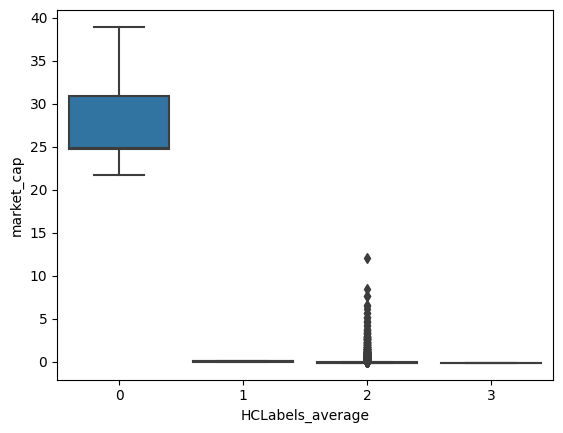

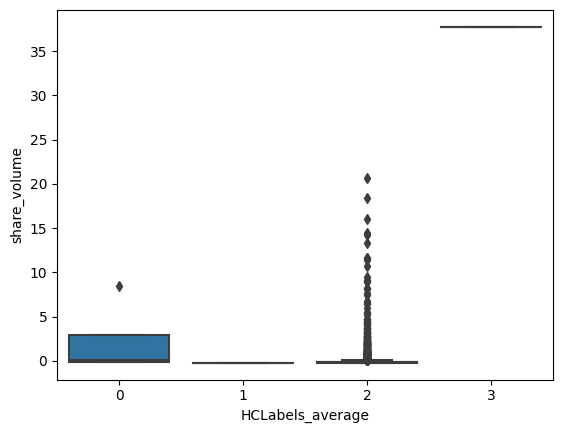

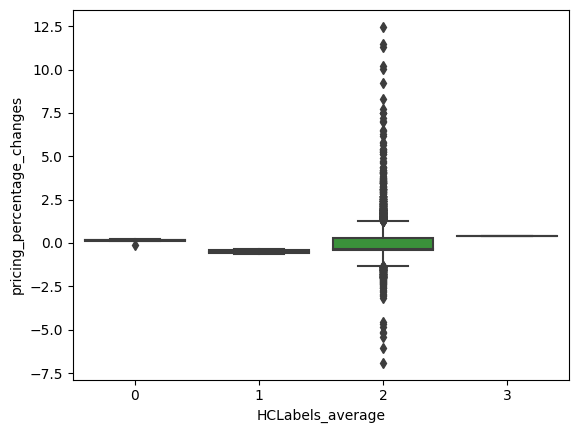

In [91]:
cols = ['price','market_cap','share_volume','pricing_percentage_changes']

for col in cols:
    sns.boxplot(x = 'HCLabels_average', y = col, data = df_hierarchical_scaled_copy)
    plt.show()